In [40]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

ModuleNotFoundError: No module named 'google'

# Load files

In [203]:
!pip install -q -U PyDrive # to get access to files

# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1joDmxc9dbVHB0XuJrLtY5nlOX339dd5R'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('Final_data.zip')
!unzip -q Final_data.zip
!ls Final_data

replace Final_data/Final_data/evaluation/00576224.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Final_data


In [5]:
import numpy as np              #numpy library is used to work with multidimensional array.
import pandas as pd             #panda used for data manipulation and analysis.                
import os                       #os library is used for loading file to use in the program
import json                     #json library parses json into a string or dict, and convert string or dict to json file.
from pathlib import Path        #support path
import matplotlib.pyplot as plt #support ploting a figure
from matplotlib import colors   #colors support converting number or argument into colors
from tqdm.notebook import tqdm_notebook as tqdm
import pickle
from torch import FloatTensor, LongTensor
import torch
from torch.nn import CrossEntropyLoss
from torch.autograd import Variable
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

import sys
sys.path.insert(0,'src')

from importlib import reload  
from generators import *
from models import *
from solvers import *
from utils import *

path = 'results/'

In [6]:
import solvers
solvers = reload(solvers)
from solvers import *

In [23]:
from importlib import reload  
import models
models = reload(models)
from models import *

In [8]:
dimension_explained('data', 'train')
dimension_explained('data','eval')
dimension_explained('data','test')

------------ train  shapes ------------
t1 all inputs are equal:  210 of which: 
t1_1 also output equal:  134
t1_2 output smaller but fixed:  43
t1_3 output bigger but fixed:  19
t1_4 output size depends on input:  14
t2 input different:  190 of which: 
t2_1 output equal to input:  128
t2_2 output smaller:  50
t2_3 output bigger:  12
------------ eval  shapes ------------
t1 all inputs are equal:  157 of which: 
t1_1 also output equal:  92
t1_2 output smaller but fixed:  32
t1_3 output bigger but fixed:  20
t1_4 output size depends on input:  13
t2 input different:  243 of which: 
t2_1 output equal to input:  178
t2_2 output smaller:  51
t2_3 output bigger:  14
------------ test  shapes ------------
t1 all inputs are equal:  41 of which: 
t1_1 also output equal:  23
t1_2 output smaller but fixed:  8
t1_3 output bigger but fixed:  7
t1_4 output size depends on input:  3
t2 input different:  59 of which: 
t2_1 output equal to input:  42
t2_2 output smaller:  15
t2_3 output bigger:  2


# All 7 task

In [6]:
# TASK 1 - Same dimension: Mirror right and down
def gener_one():
    skeleton=np.random.randint(2,size=(3,4))
    color=np.random.randint(1, 10)
    inp=np.where(skeleton==0, 0, color)
    flip_right=np.concatenate((inp,np.flip(inp, axis=1)), axis=1)
    out=np.concatenate((flip_right,np.flip(flip_right, axis=0)), axis=0)
    return(inp, out)

In [7]:
# TASK 2 - Same dimension: Concatenate and flip central row
def gener_two():
    inp=np.random.randint(1,10,size=(2,2))
    flip=np.flip(inp, axis=1)
    conc1=np.concatenate((inp, inp, inp), axis=1)
    conc2=np.concatenate((flip, flip, flip), axis=1)
    out=np.concatenate((conc1, conc2, conc1), axis=0)
    return(inp, out)

In [8]:
# TASK 3 - Same dimension: Pattern filler
def gener_three():
    a = np.random.randint(2, 10, (8, 8))
    a = np.where(a==4, 1, a)
    m = np.tril(a) + np.tril(a, -1).T
    m = np.concatenate((m, np.flip(m, axis=0)), axis=0)
    out= np.concatenate((m, np.flip(m)), axis=1)
    inp = out.copy()

    p1=np.random.randint(1, 13)
    p2=np.random.randint(p1+2, p1+5)
    p3=np.random.randint(1, 13)
    p4=np.random.randint(p3+2, p3+5)

    inp[p1:p2, p3:p4]=4

    p1=np.random.randint(1, 13)
    p2=np.random.randint(p1+2, p1+5)
    p3=np.random.randint(1, 13)
    p4=np.random.randint(p3+2, p3+5)

    inp[p1:p2, p3:p4]=4 
    
    return(inp, out)

In [9]:
# TASK 4 - Different dimension: Denoise
def gener_four():
    dim1=np.random.randint(10,15)
    dim2=np.random.randint(13,18)
    out=np.zeros((dim1,dim2))
    col=np.random.choice([2,3,5])
    colno=np.random.choice([1,4,8])
    nsquare=np.random.randint(3,5)
    nnoise=np.random.randint(10,20)
    for sq in range(0,nsquare):
        p1=np.random.randint(0, dim1-1)
        p2=np.random.randint(p1+2, p1+8)
        p3=np.random.randint(0, dim2-1)
        p4=np.random.randint(p3+2, p3+8)

        out[p1:p2, p3:p4]=col

    inp=out.copy()

    for noise in range(0,nnoise):
        p1=np.random.randint(0, dim1)
        p2=np.random.randint(0, dim2)

        inp[p1,p2]=colno
    return(inp, out)

In [10]:
# TASK 5 - Different dimension: 2 squares
def gener_five():
    dim1=np.random.randint(5,11)
    dim2=np.random.randint(5,11)
    out=np.zeros((dim1,dim2))
    inp=out.copy()
    col=np.random.randint(1,10)
    col2=np.random.randint(1,10)
    nsquare=np.random.randint(1,3)
    
    flippoints=np.random.randint(1,3)
    
    while col2==col:
        col2=np.random.randint(1,10)

    if nsquare==1:
        p1=np.random.randint(0, dim1-2)
        p2=np.random.randint(p1+2,dim1)
        p3=np.random.randint(0, dim2-2)
        p4=np.random.randint(p3+2,dim2)

        out[p1:p2+1, p3:p4+1]=col
        inp[p1, p3]=col
        inp[p2, p4]=col
    if nsquare==2:
        if dim1>dim2:
            p1= np.random.randint(0, dim1-3)
            p2= np.random.randint(p1+1, dim1-2)
            p11= np.random.randint(p2+1, dim1-1)
            p22= np.random.randint(p11+1, dim1)
            p3= np.random.randint(0, dim2-3)
            p4= np.random.randint(p3+1, dim2)
            p33= np.random.randint(0, dim2-3)
            p44= np.random.randint(p33+1, dim2)

            out[p1:p2+1, p3:p4+1]=col            
            out[p11:p22+1, p33:p44+1]=col2
            
            if flippoints==1:
                inp[p1, p3]=col
                inp[p2, p4]=col            
                inp[p22, p33]=col2
                inp[p11, p44]=col2
            else:
                inp[p2, p3]=col
                inp[p1, p4]=col            
                inp[p11, p33]=col2
                inp[p22, p44]=col2
                
        else:
            p1= np.random.randint(0, dim1-3)
            p2= np.random.randint(p1+1, dim1)
            p11= np.random.randint(0, dim1-3)
            p22= np.random.randint(p11+1, dim1)
            p3= np.random.randint(0, dim2-3)
            p4= np.random.randint(p3+1, dim2-2)
            p33= np.random.randint(p4+1, dim2-1)
            p44= np.random.randint(p33+1, dim2)

            out[p1:p2+1, p3:p4+1]=col            
            out[p11:p22+1, p33:p44+1]=col2
            
            if flippoints==1:
                inp[p1, p3]=col
                inp[p2, p4]=col            
                inp[p22, p33]=col2
                inp[p11, p44]=col2
            else:
                inp[p2, p3]=col
                inp[p1, p4]=col            
                inp[p11, p33]=col2
                inp[p22, p44]=col2
    return(inp, out)

In [11]:
# TASK 6 - Different dimension: smallest squares
def gener_six():
    dim1=np.random.randint(8,21)
    dim2=np.random.randint(8,21)
    inp=np.zeros((dim1,dim2))
    nsquare=np.random.randint(2,6)
    colors=np.random.choice(range(1,10),5, replace=False)
    sqs=[]
    for i in range(0, nsquare):
        p1=np.random.randint(1, dim1-3)
        p2=np.random.randint(p1+1,dim1-1)
        p3=np.random.randint(1, dim2-3)
        p4=np.random.randint(p3+1,dim2-1)
        sqs.append([((p2-p1)*(p4-p3)), p1,p2,p3,p4, colors[i]])
        
    sortt=sorted(sqs, reverse=True)
    for sq in sortt:
        _,p1,p2,p3,p4,col=sq
        inp[p1:p2+1, p3:p4+1]=col
    _,p1,p2,p3,p4,col=sortt[-1]
    
    out=np.ones((p2-p1,p4-p3))*col
    
    
    return(inp, out)

In [12]:
# TASK 7 - Different dimension: inverter
def gener_seven():
    dim1=np.random.randint(18,26)
    dim2=np.random.randint(18,26)
    colors=np.random.choice(range(1,10),2, replace=False)
    inp=np.zeros((dim1,dim2))
    
    nnoise=np.random.randint(15,50)
    for noise in range(0,nnoise):
        p1=np.random.randint(0, dim1)
        p2=np.random.randint(0, dim2)

        inp[p1,p2]=colors[0]
        
    
    
    skel=np.random.randint(2,size=(3,3))
    out=skel*colors[0]
    topaste=np.kron(skel, np.ones((4,4)))*colors[1]
    
    p1=np.random.randint(0, dim1-12)
    p2=np.random.randint(0,dim2-12)
    
    inp[p1:p1+12, p2:p2+12]=topaste
    
    return(inp, out)

# TASK 1


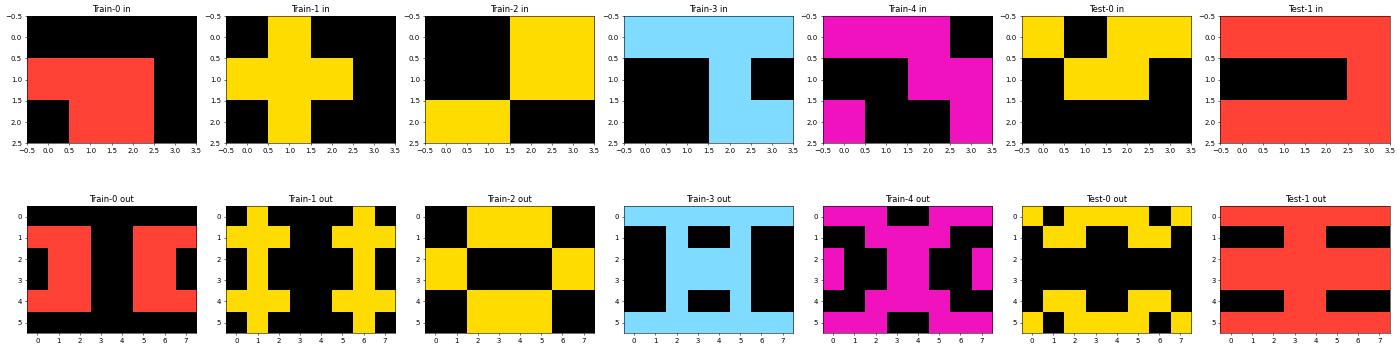

In [13]:
task=task_builder(gener_one, 5, 2)
plot_task(task)

In [14]:
data=[task_builder(gener_one, 10000, 100)]

### FCN

##### SHALLOW

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.73s/it]


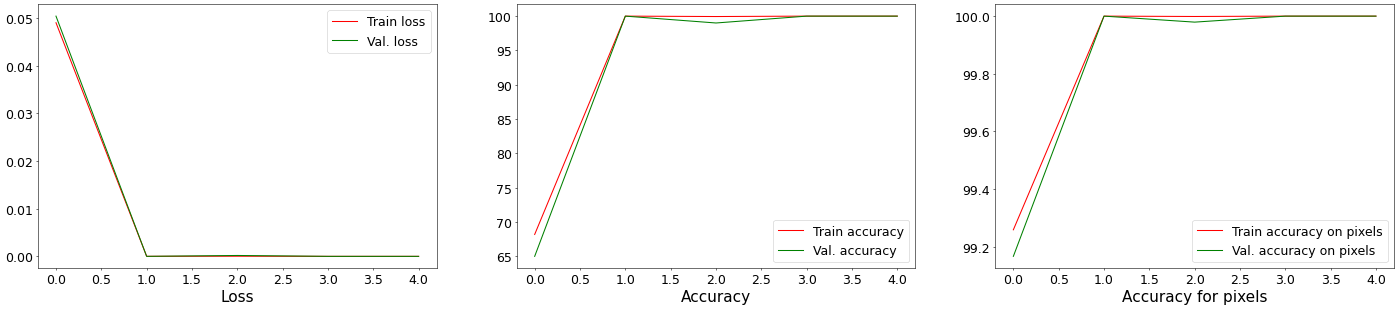

In [16]:
# Training
FullyCon_result_T1, FullyCon__predictions_T1, FullyCon_wrong_pred_T1 = evaluate_metrics(TaskSolver(), 
                                                                                        data, 
                                                                                        FullyCon, CrossEntropyLoss, 
                                                                                        n_epoch=5, device=device,
                                                                                        lr = 0.1, verbose=False, 
                                                                                        attention = False)

save_results(path, [FullyCon_result_T1, FullyCon__predictions_T1, FullyCon_wrong_pred_T1], 
             ['FullyCon_result_T1', 'FullyCon__predictions_T1', 'FullyCon_wrong_pred_T1'])


plot_metrics(load_results(path, 'FullyCon_result_T1'))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

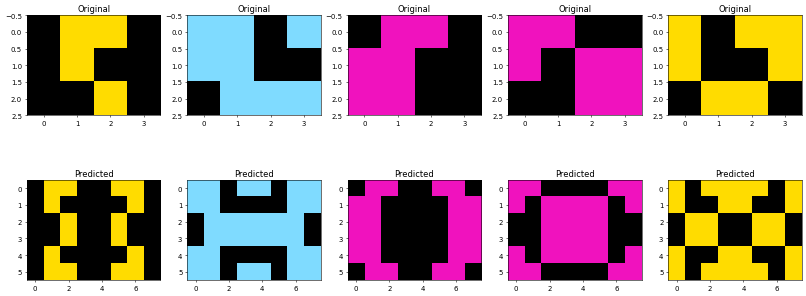

In [17]:
compare_plots(load_results(path, 'FullyCon__predictions_T1'), n = 5)

In [18]:
len(load_results(path,'FullyCon_wrong_pred_T1')) # all results are correct

0

##### DEEP

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [08:54<00:00, 106.87s/it]


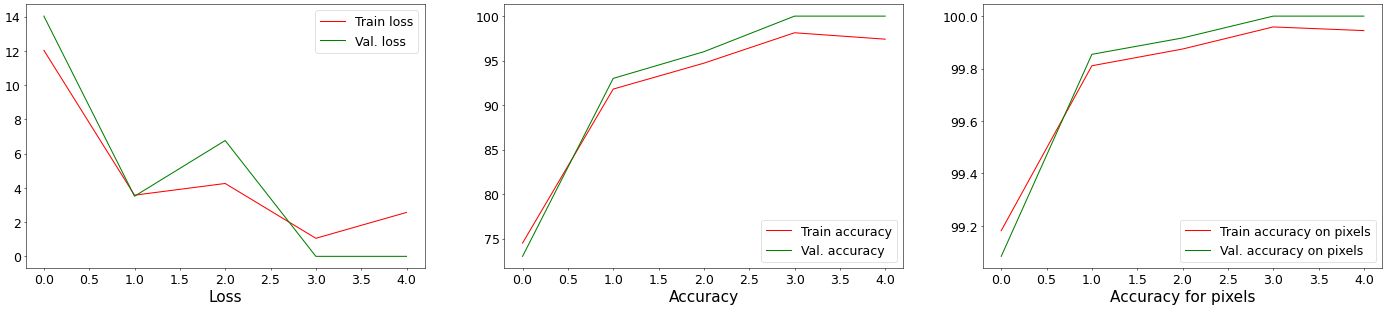

In [42]:
# Training
FullyConDeep_result_T1, FullyConDeep__predictions_T1, FullyConDeep_wrong_pred_T1 = evaluate_metrics(TaskSolver(), 
                                                                                        data, 
                                                                                        FullyCon_deep, CrossEntropyLoss, 
                                                                                        n_epoch=5, device=device,
                                                                                        lr = 0.1, verbose=False, 
                                                                                        attention = False)

save_results(path, [FullyConDeep_result_T1, FullyConDeep__predictions_T1, FullyConDeep_wrong_pred_T1], 
             ['FullyConDeep_result_T1', 'FullyConDeep__predictions_T1', 'FullyConDeep_wrong_pred_T1'])


plot_metrics(load_results(path, 'FullyConDeep_result_T1'))


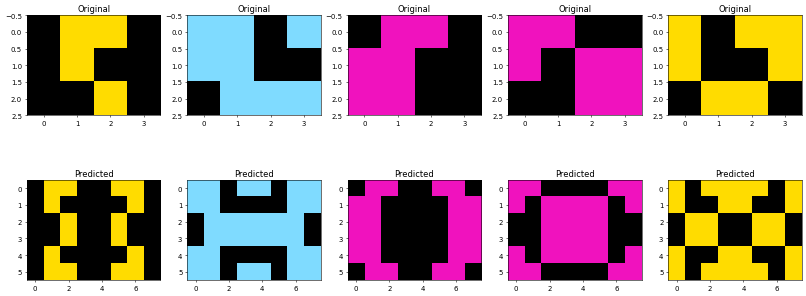

In [46]:
compare_plots(load_results(path, 'FullyConDeep__predictions_T1'), n = 5)

### LSTM

##### ATTENTION

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]src\models.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = F.softmax(att)
100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [13:16<00:00, 159.23s/it]
C:\Users\Egon\Anaconda3\envs\pytorch\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


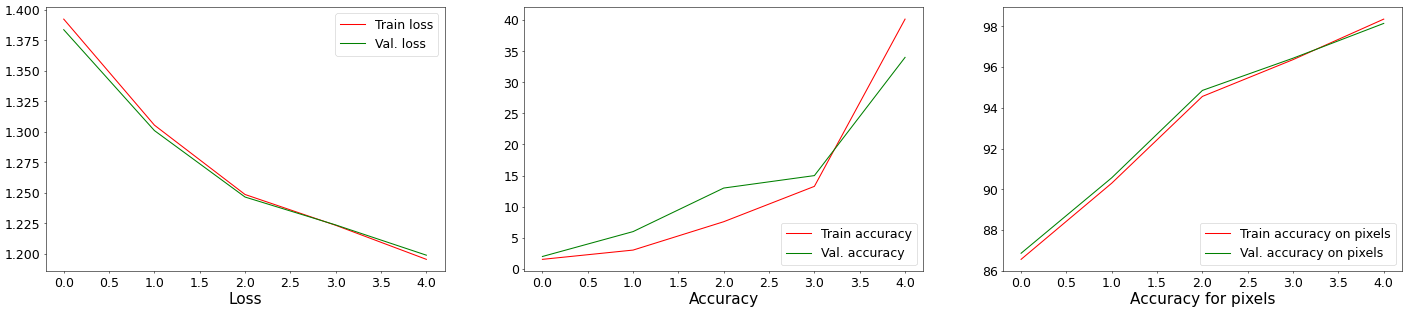

In [47]:
# Training with attention
LSTM_result_T1, LSTM_predictions_T1, LSTM_wrong_pred_T1 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            LSTM, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [LSTM_result_T1, LSTM_predictions_T1, LSTM_wrong_pred_T1], 
             ['LSTM_result_T1', 'LSTM_predictions_T1', 'LSTM_wrong_pred_T1'])

plot_metrics(load_results(path, 'LSTM_result_T1'))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

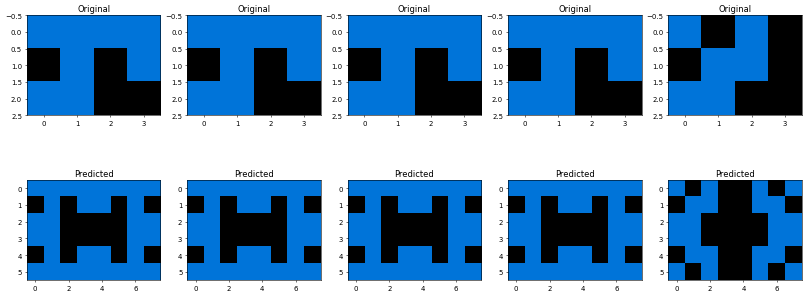

In [51]:
correct = find_correct_pred(load_results(path, 'LSTM_predictions_T1'), 
                            load_results(path, 'LSTM_wrong_pred_T1'))
compare_plots(correct, n = len(correct)) # 5 correct predictions

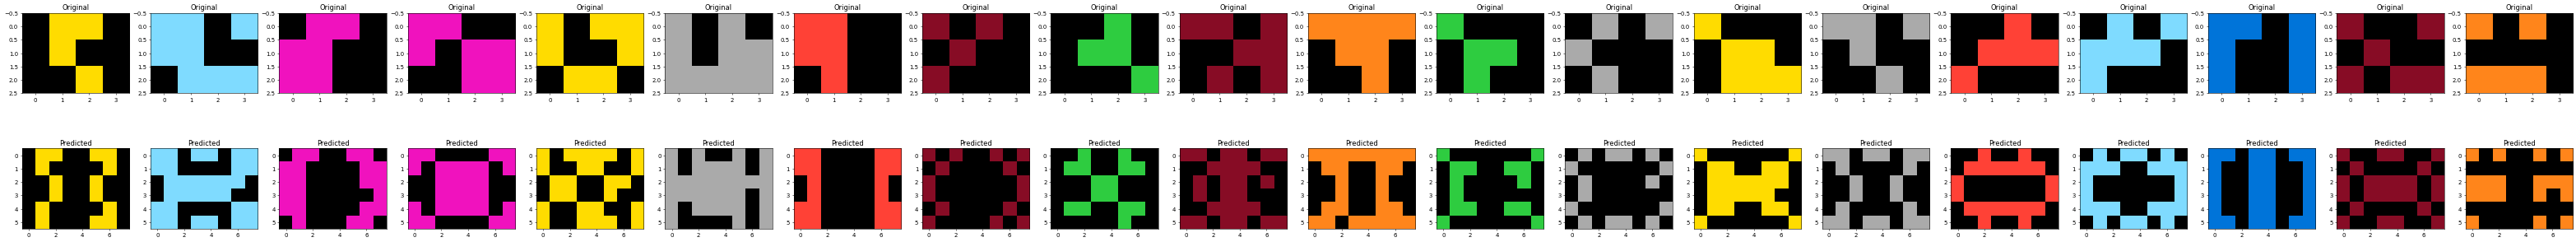

In [54]:
compare_plots(load_results(path, 'LSTM_predictions_T1'), n = 20) # 5 wrong predictions

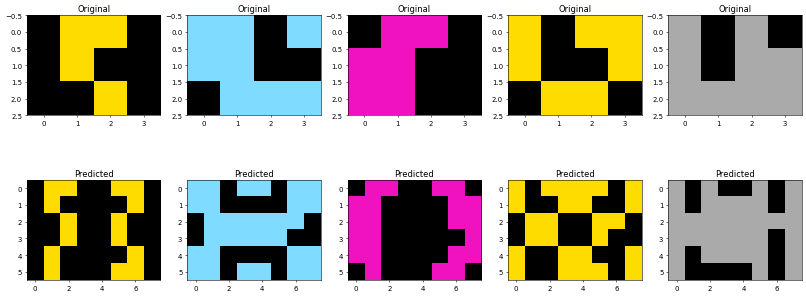

In [49]:
compare_plots(load_results(path, 'LSTM_wrong_pred_T1'), n = 5) # 5 wrong predictions

##### NO ATTENTION


 20%|██        | 1/5 [00:42<02:48, 42.19s/it]


Epoch: [1/5]
Train loss is: 1.3940496338248254
Validation loss is: 1.3928398561477662
Train accuracy is: 0.33 %
Train accuracy for pixels is: 88.54895833333333 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 89.04166666666667 %



 40%|████      | 2/5 [01:24<02:06, 42.11s/it]


Epoch: [2/5]
Train loss is: 1.373323172557354
Validation loss is: 1.3734434950351715
Train accuracy is: 5.01 %
Train accuracy for pixels is: 89.51666666666667 %
Validation accuracy is: 4.0 %
Validation accuracy for pixels is: 89.875 %



 60%|██████    | 3/5 [02:06<01:24, 42.07s/it]


Epoch: [3/5]
Train loss is: 1.2740564212799073
Validation loss is: 1.2693238496780395
Train accuracy is: 14.52 %
Train accuracy for pixels is: 93.815 %
Validation accuracy is: 18.0 %
Validation accuracy for pixels is: 94.29166666666667 %



 80%|████████  | 4/5 [02:48<00:42, 42.10s/it]


Epoch: [4/5]
Train loss is: 1.2762479894399643
Validation loss is: 1.2787729346752166
Train accuracy is: 13.67 %
Train accuracy for pixels is: 93.06041666666667 %
Validation accuracy is: 15.0 %
Validation accuracy for pixels is: 92.95833333333333 %



100%|██████████| 5/5 [03:30<00:00, 42.11s/it]


Epoch: [5/5]
Train loss is: 1.2178052581071854
Validation loss is: 1.2167778050899505
Train accuracy is: 26.7 %
Train accuracy for pixels is: 97.47083333333333 %
Validation accuracy is: 26.0 %
Validation accuracy for pixels is: 97.5625 %



/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


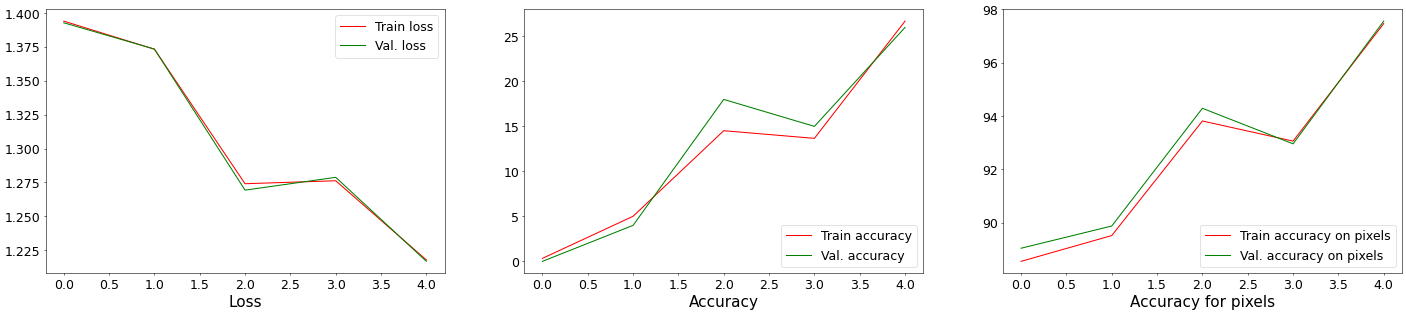

In [139]:
# Training without attention 
LSTM_no_result_T1, LSTM_no_predictions_T1, LSTM_no_wrong_pred_T1 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            LSTM, CrossEntropyLoss, 
                                                                            attention = None,
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=True)

save_results(path, [LSTM_no_result_T1, LSTM_no_predictions_T1, LSTM_no_wrong_pred_T1], 
             ['LSTM_no_result_T1', 'LSTM_no_predictions_T1', 'LSTM_no_wrong_pred_T1'])


plot_metrics(load_results(path, 'LSTM_no_result_T1'))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

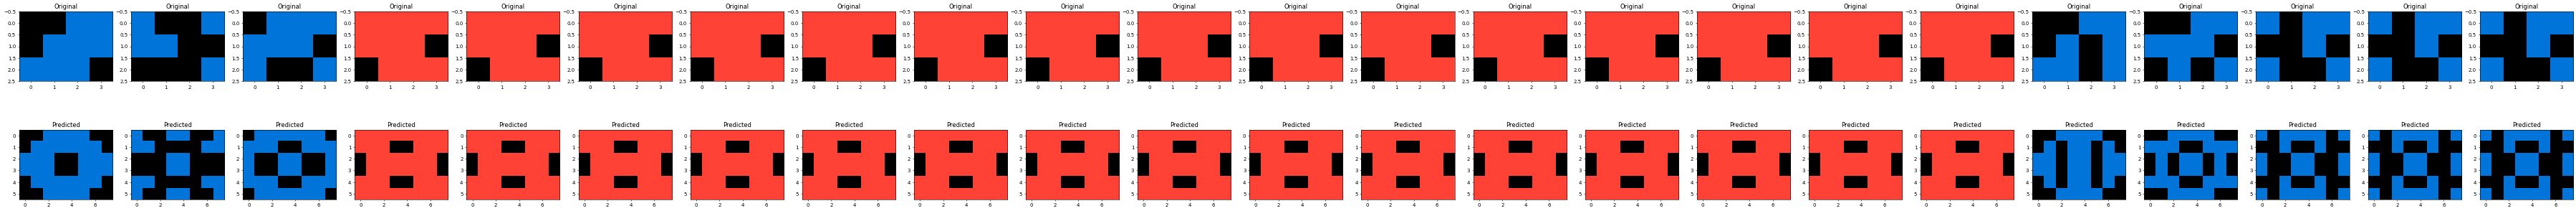

In [241]:
correct = find_correct_pred(load_results(path, 'LSTM_no_predictions_T1'), 
                            load_results(path, 'LSTM_no_wrong_pred_T1'))
compare_plots(correct, n = len(correct)) # 5 correct predictions

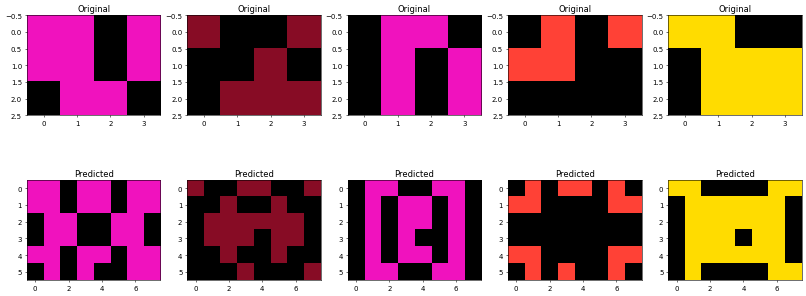

In [244]:
compare_plots(load_results(path, 'LSTM_no_wrong_pred_T1'), n = 5) # 5 wrong predictions

## CNN

In [93]:
import models
models = reload(models)
from models import *

##### CNN 5 ATTENTION

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]src\models.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = F.softmax(att)
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:56<00:00, 59.24s/it]
C:\Users\Egon\Anaconda3\envs\pytorch\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


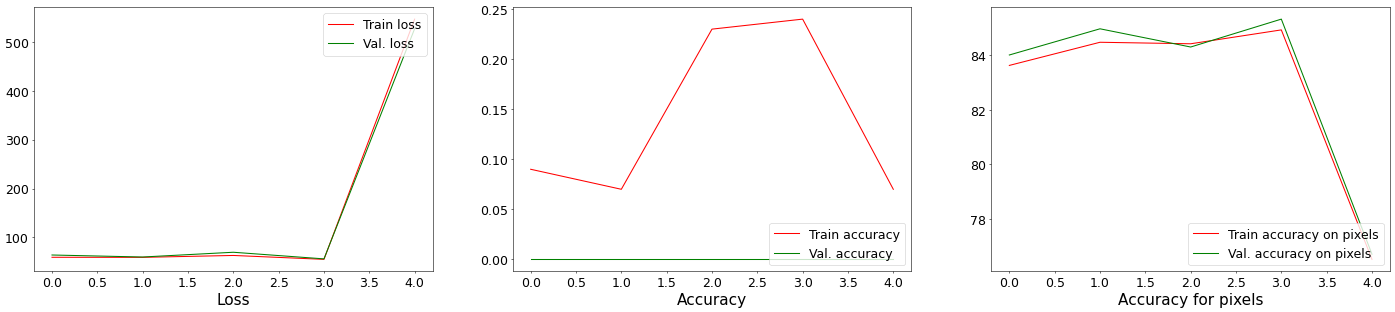

In [100]:
# Training with attention
CNN_result_T1, CNN_predictions_T1, CNN_wrong_pred_T1 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_5, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [CNN_result_T1, CNN_predictions_T1, CNN_wrong_pred_T1], 
             ['CNN_result_T1', 'CNN_predictions_T1', 'CNN_wrong_pred_T1'])


plot_metrics(load_results(path,'CNN_result_T1'))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

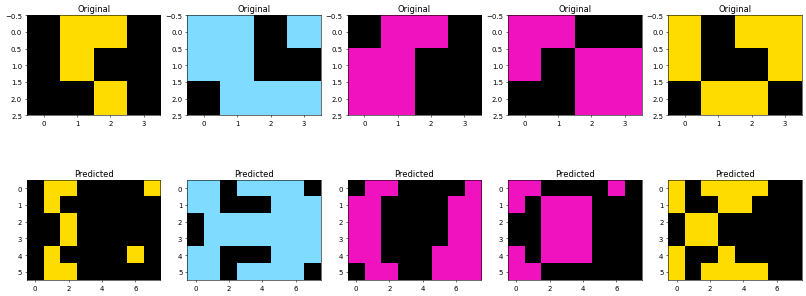

In [99]:
compare_plots(load_results(path, 'CNN_wrong_pred_T1'), n = 5) # 5 wrong predictions

##### CNN 3 ATTENTION

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:33<00:00, 54.65s/it]


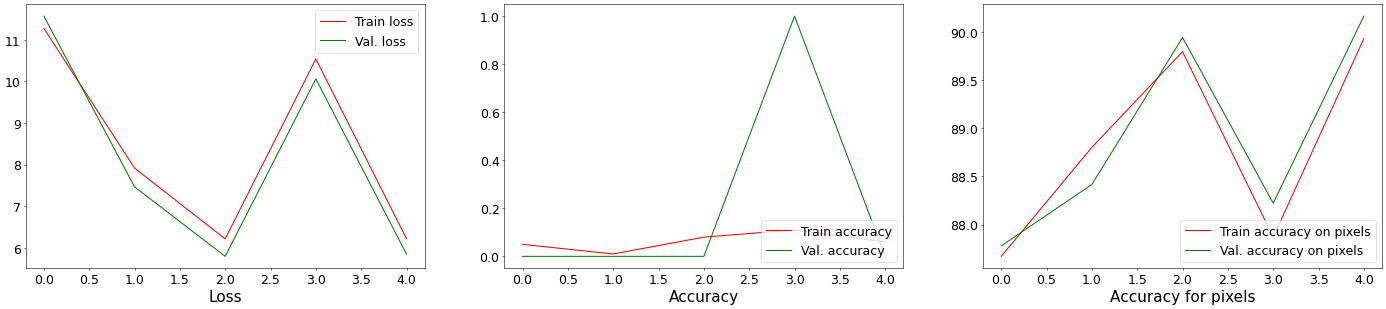

In [26]:
CNN3_result_T1, CNN3_predictions_T1, CNN3_wrong_pred_T1 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_3, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [CNN3_result_T1, CNN3_predictions_T1, CNN3_wrong_pred_T1], 
             ['CNN3_result_T1', 'CNN3_predictions_T1', 'CNN3_wrong_pred_T1'])


plot_metrics(load_results(path,'CNN3_result_T1'))

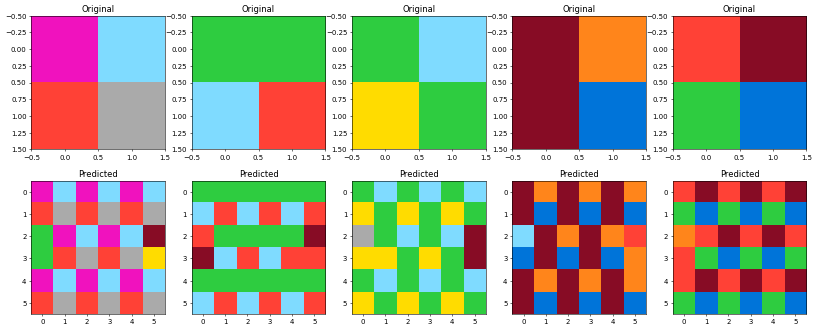

In [27]:
compare_plots(load_results(path, 'CNN3_wrong_pred_T1'), n = 5) # 5 wrong predictions

##### 5  NO ATTENTION

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:53<00:00, 46.78s/it]


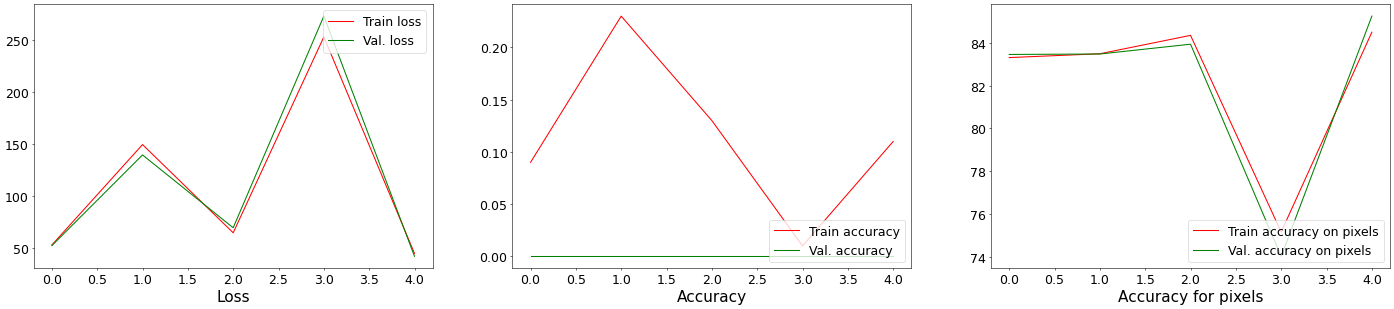

NameError: name 'output' is not defined

In [108]:
# Training without attention
CNN_no_result_T1, CNN_no_predictions_T1, CNN_no_wrong_pred_T1 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_5, CrossEntropyLoss, 
                                                                            attention = None,
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [CNN_no_result_T1, CNN_no_predictions_T1, CNN_no_wrong_pred_T1], 
             ['CNN_no_result_T1', 'CNN_no_predictions_T1', 'CNN_no_wrong_pred_T1'])


plot_metrics(load_results(path, 'CNN_no_result_T1'))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

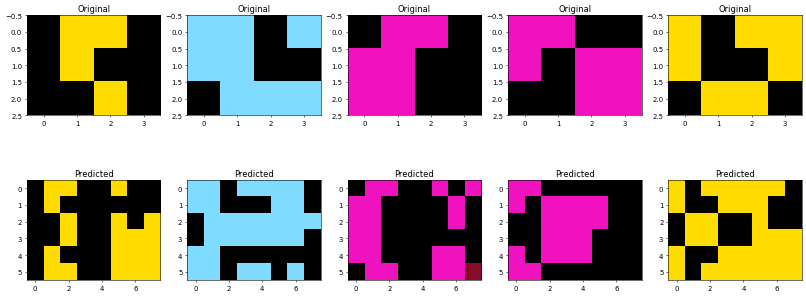

In [109]:
compare_plots(load_results(path, 'CNN_no_wrong_pred_T1'), n = 5) # 5 wrong predictions

### GRU

In [116]:
from importlib import reload  
import models
models = reload(models)
from models import *

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:41<00:00, 56.25s/it]


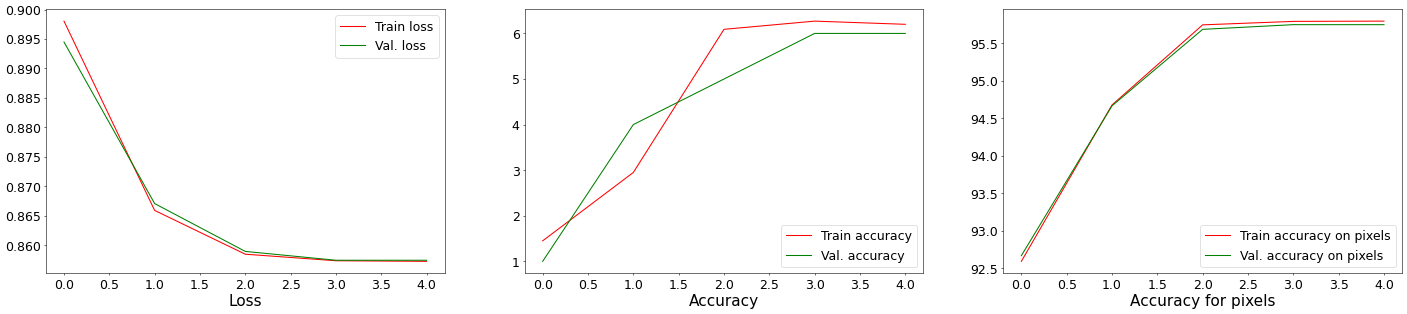

In [117]:
# Training with attention
GRU_result_T1, GRU_predictions_T1, GRU_wrong_pred_T1 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            GRU, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [GRU_result_T1, GRU_predictions_T1, GRU_wrong_pred_T1], 
             ['GRU_result_T1', 'GRU_predictions_T1', 'GRU_wrong_pred_T1'])

plot_metrics(load_results(path, 'GRU_result_T1'))

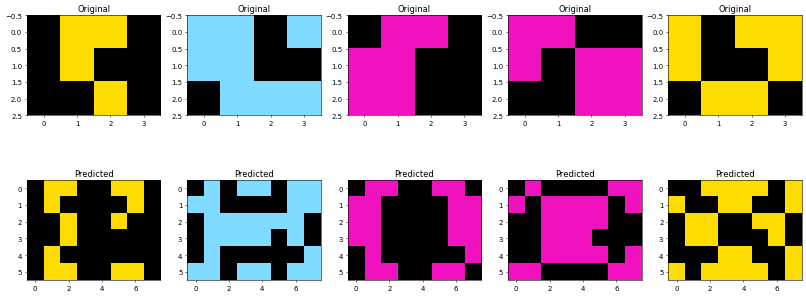

In [122]:
compare_plots(load_results(path, 'GRU_predictions_T1'), n = 5) 

# Task 2

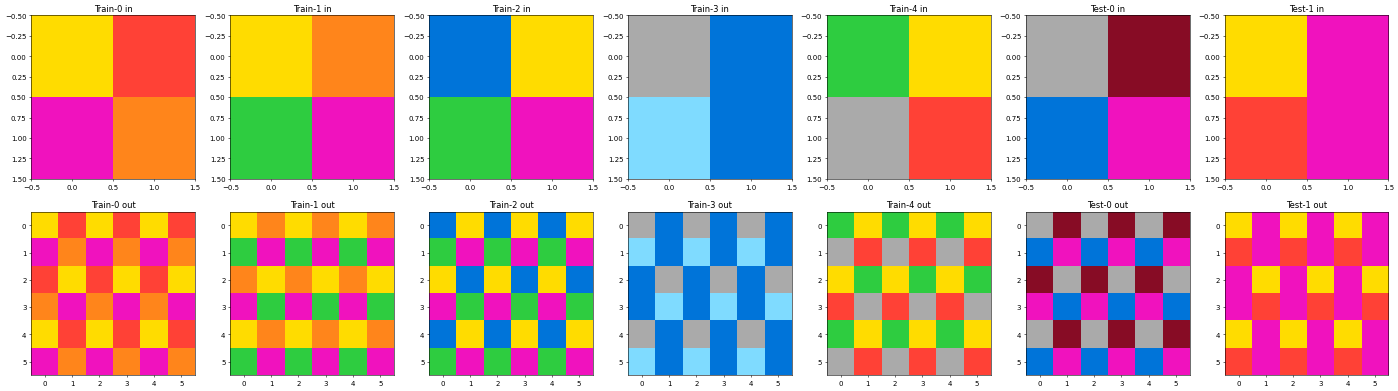

In [25]:
task=task_builder(gener_two, 5, 2)
plot_task(task)

In [15]:
data=[task_builder(gener_two, 10000, 100)]

## FCN

##### shallow

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.47s/it]


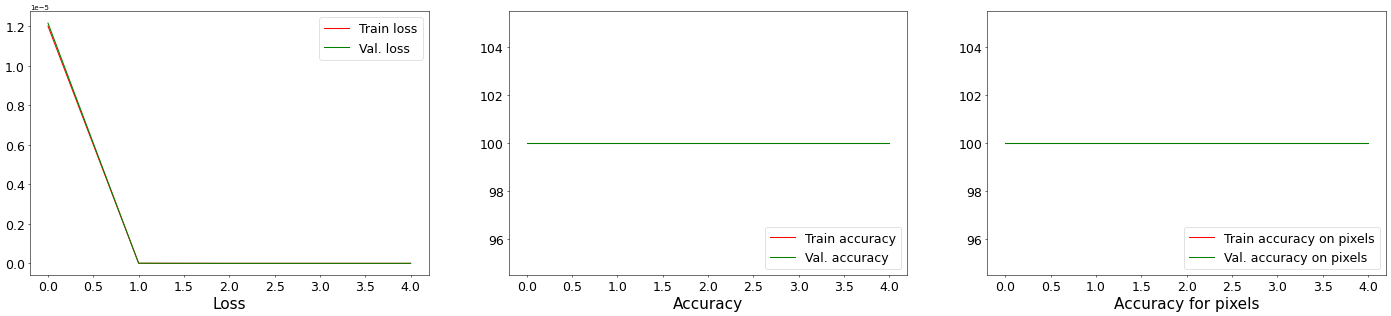

NameError: name 'output' is not defined

In [125]:
# Training
FullyCon_result_T2, FullyCon__predictions_T2, FullyCon_wrong_pred_T2 = evaluate_metrics(TaskSolver(), 
                                                                                        data, 
                                                                                        FullyCon, CrossEntropyLoss, 
                                                                                        n_epoch=5, device=device,
                                                                                        lr = 0.1, verbose=False, attention = False)

save_results(path, [FullyCon_result_T2, FullyCon__predictions_T2, FullyCon_wrong_pred_T2], 
             ['FullyCon_result_T2', 'FullyCon__predictions_T2', 'FullyCon_wrong_pred_T2'])


plot_metrics(load_results(path, 'FullyCon_result_T2'))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

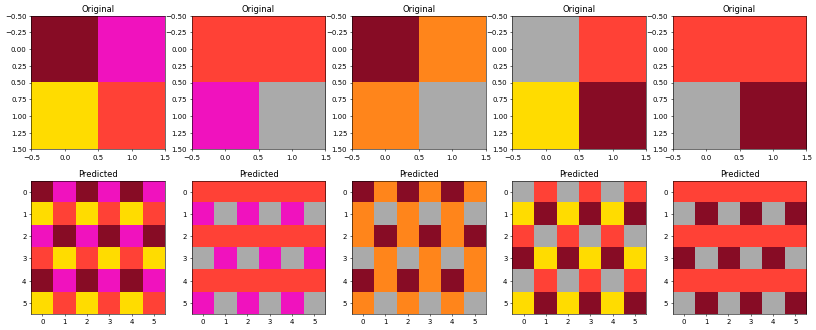

In [126]:
compare_plots(load_results(path, 'FullyCon__predictions_T2'), n=5) # 5 correct predictions

##### dense 

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:13<00:00, 38.75s/it]


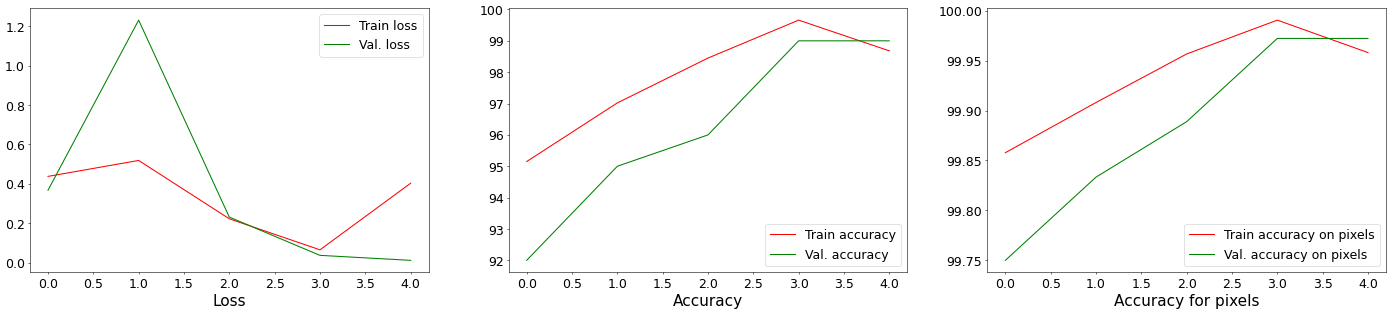

In [127]:
FullyConDeep_result_T2, FullyConDeep__predictions_T2, FullyConDeep_wrong_pred_T2 = evaluate_metrics(TaskSolver(), 
                                                                                        data, 
                                                                                        FullyCon_deep, CrossEntropyLoss, 
                                                                                        n_epoch=5, device=device,
                                                                                        lr = 0.1, verbose=False, attention = False)

save_results(path, [FullyConDeep_result_T2, FullyConDeep__predictions_T2, FullyConDeep_wrong_pred_T2], 
             ['FullyConDeep_result_T2', 'FullyConDeep__predictions_T2', 'FullyConDeep_wrong_pred_T2'])


plot_metrics(load_results(path, 'FullyConDeep_result_T2'))


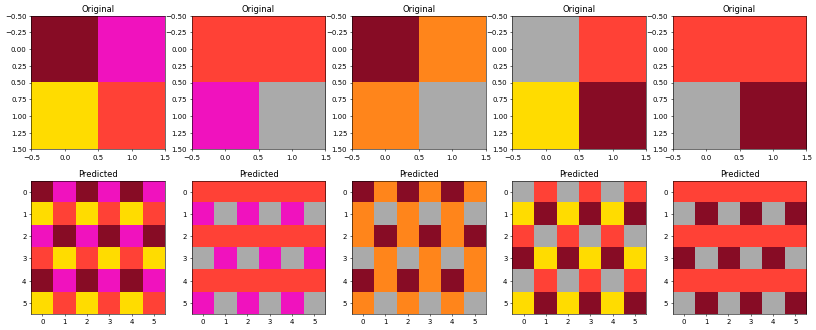

In [128]:
compare_plots(load_results(path, 'FullyCon__predictions_T2'), n=5) # 5 correct predictions


## LSTM

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:44<00:00, 56.86s/it]


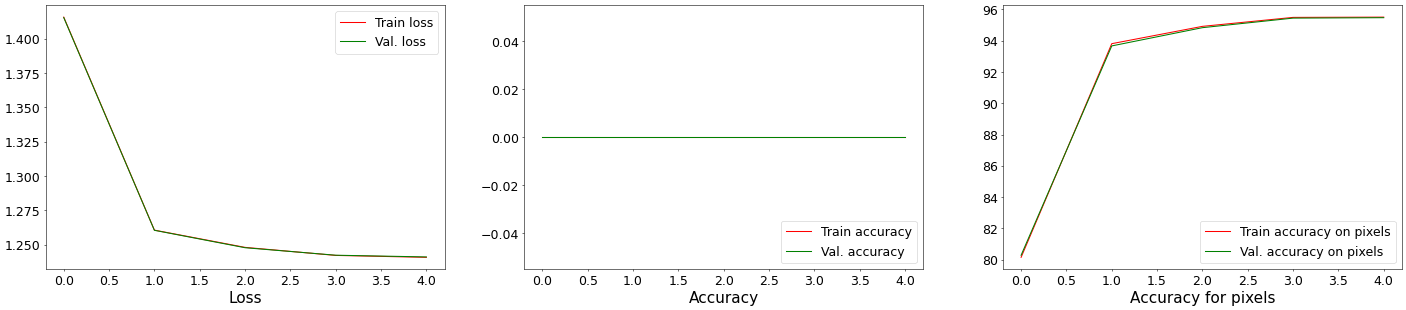

In [130]:
# Training with attention
LSTM_result_T2, LSTM_predictions_T2, LSTM_wrong_pred_T2 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            LSTM, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [LSTM_result_T2, LSTM_predictions_T2, LSTM_wrong_pred_T2], 
             ['LSTM_result_T2', 'LSTM_predictions_T2', 'LSTM_wrong_pred_T2'])


plot_metrics(load_results(path, 'LSTM_result_T2'))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

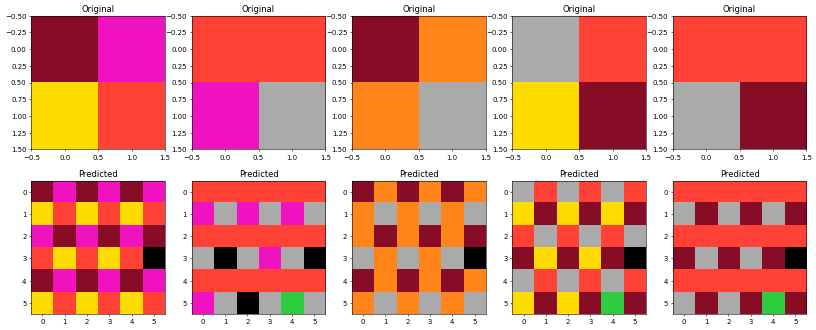

In [131]:
compare_plots(load_results(path, 'LSTM_wrong_pred_T2'), n=5) # 5 wrong predictions

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:46<00:00, 45.35s/it]


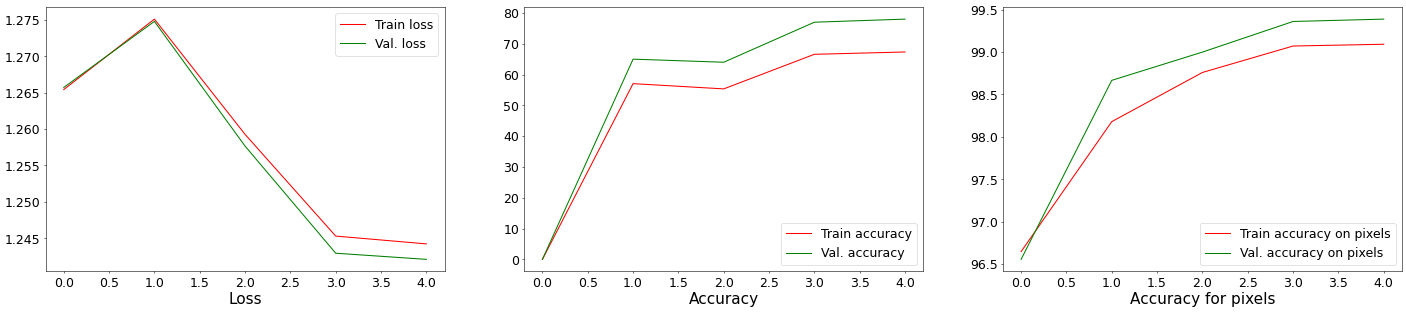

In [133]:
# Training without attention
LSTM_no_result_T2, LSTM_no_predictions_T2, LSTM_no_wrong_pred_T2 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            LSTM, CrossEntropyLoss, 
                                                                            attention = None,
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [LSTM_no_result_T2, LSTM_no_predictions_T2, LSTM_no_wrong_pred_T2], 
             ['LSTM_no_result_T2', 'LSTM_no_predictions_T2', 'LSTM_no_wrong_pred_T2'])


plot_metrics(load_results(path, 'LSTM_no_result_T2'))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

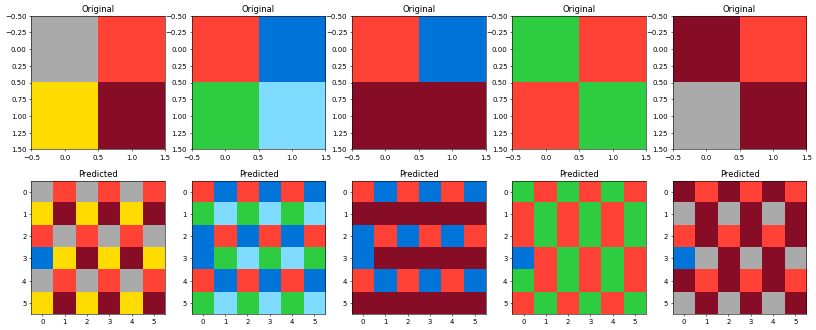

In [134]:
compare_plots(load_results(path, 'LSTM_no_wrong_pred_T2'), n=5) # 5 wrong predictions

## CNN

##### 5 ATTENTION

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:38<00:00, 55.79s/it]


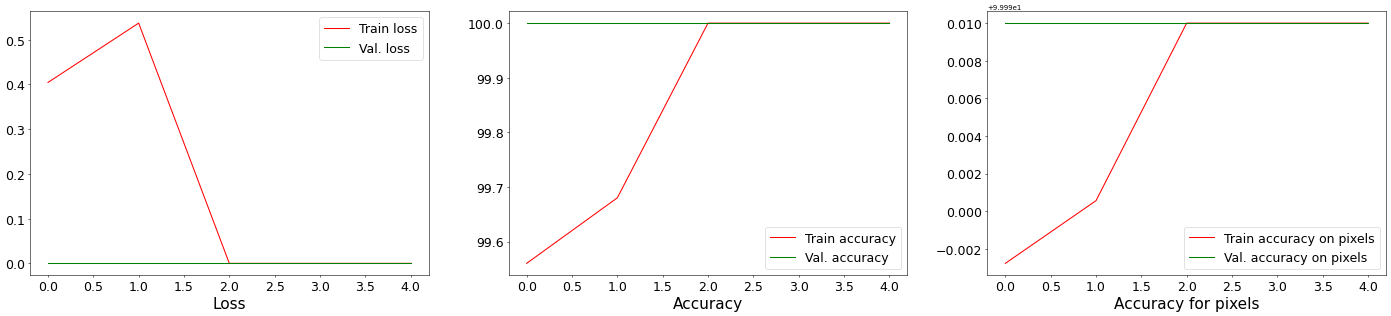

NameError: name 'output' is not defined

In [135]:
# Training
CNN_result_T2, CNN_predictions_T2, CNN_wrong_pred_T2 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_5, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [CNN_result_T2, CNN_predictions_T2, CNN_wrong_pred_T2], 
             ['CNN_result_T2', 'CNN_predictions_T2', 'CNN_wrong_pred_T2'])


plot_metrics(load_results(path, 'CNN_result_T2'))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

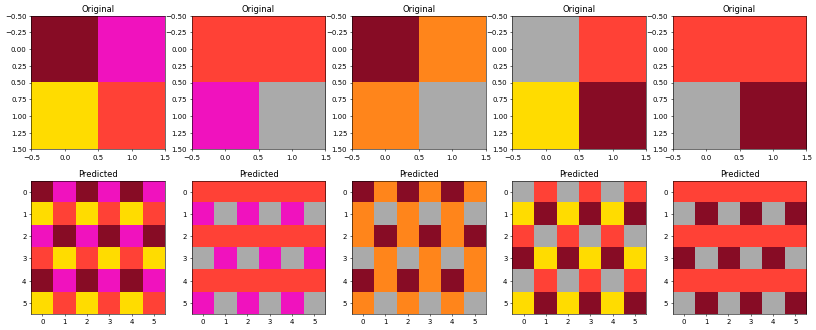

In [137]:
compare_plots(load_results(path, 'CNN_predictions_T2'), n=5) # 5 wrong predictions

##### 10 ATTENTION

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:36<00:00, 55.30s/it]


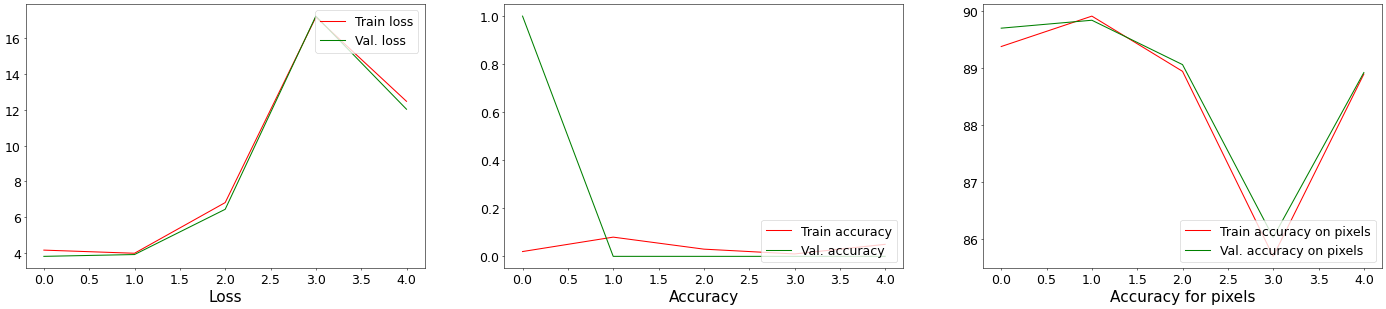

In [24]:
# Training
CNN3_result_T2, CNN3_predictions_T2, CNN3_wrong_pred_T2 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_3, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [CNN3_result_T2, CNN3_predictions_T2, CNN3_wrong_pred_T2], 
             ['CNN3_result_T2', 'CNN3_predictions_T2', 'CNN3_wrong_pred_T2'])


plot_metrics(load_results(path, 'CNN3_result_T2'))


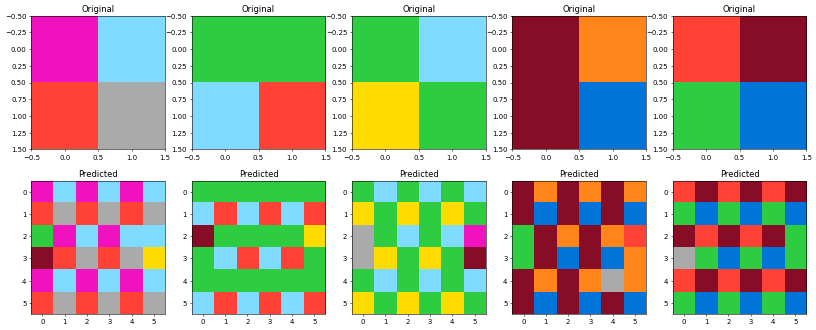

In [25]:
compare_plots(load_results(path, 'CNN3_predictions_T2'), n=5)

##### 5 NO ATTENTION

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:44<00:00, 44.80s/it]


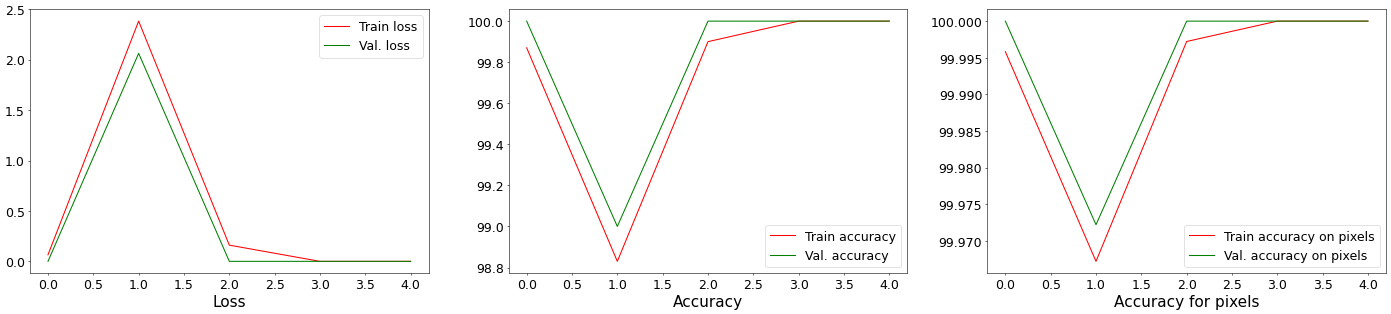

NameError: name 'output' is not defined

In [138]:
# Training wihtout attention
CNN_no_result_T2, CNN_no_predictions_T2, CNN_no_wrong_pred_T2 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_5, CrossEntropyLoss, 
                                                                            attention = None,
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [CNN_no_result_T2, CNN_no_predictions_T2, CNN_no_wrong_pred_T2], 
             ['CNN_no_result_T2', 'CNN_no_predictions_T2', 'CNN_no_wrong_pred_T2'])


plot_metrics(load_results(path, 'CNN_no_result_T2'))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

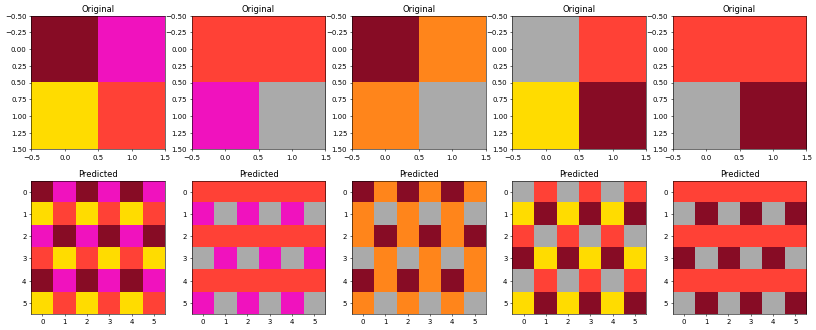

In [140]:
compare_plots(load_results(path, 'CNN_predictions_T2'), n=5) # 5 wrong predictions

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:39<00:00, 55.93s/it]


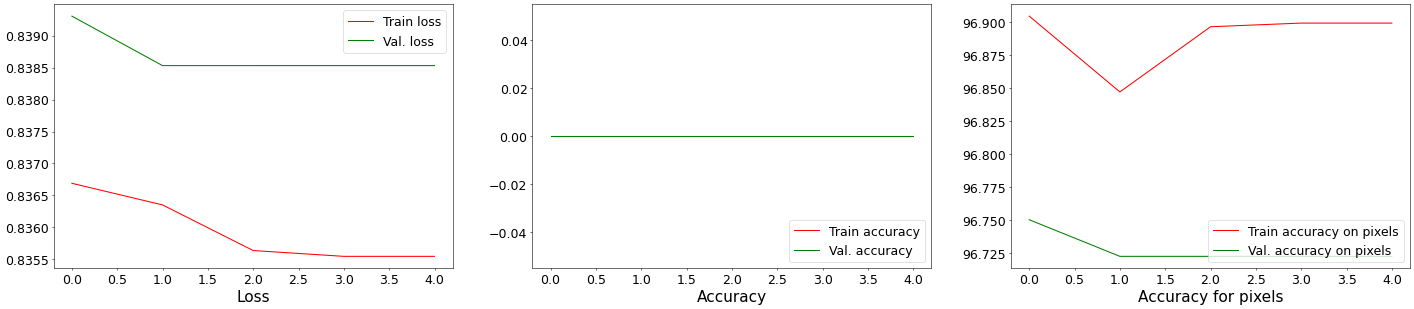

In [146]:
# Training with attention
GRU_result_T2, GRU_predictions_T2, GRU_wrong_pred_T2 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            GRU, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [GRU_result_T2, GRU_predictions_T2, GRU_wrong_pred_T2], 
             ['GRU_result_T2', 'GRU_predictions_T2', 'GRU_wrong_pred_T2'])

plot_metrics(load_results(path, 'GRU_result_T2'))

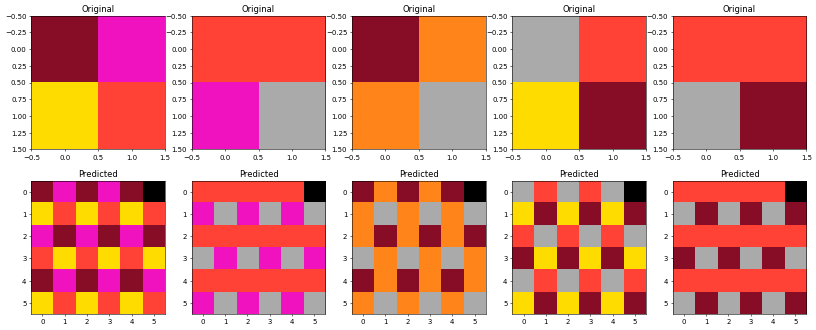

In [147]:
compare_plots(load_results(path, 'GRU_predictions_T2'), n=5)

# Task 3

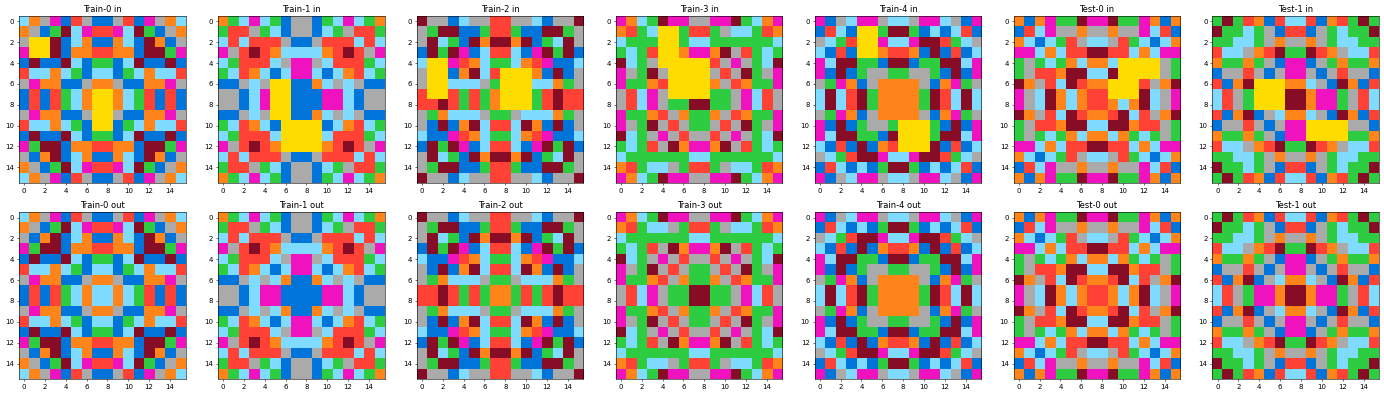

In [49]:
task=task_builder(gener_three, 5, 2)
plot_task(task)
# input.shape == output.shape and inputs have same shape between each others

In [65]:
data=[task_builder(gener_three, 10000, 100)]

## FCN

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [15:50<00:00, 190.01s/it]


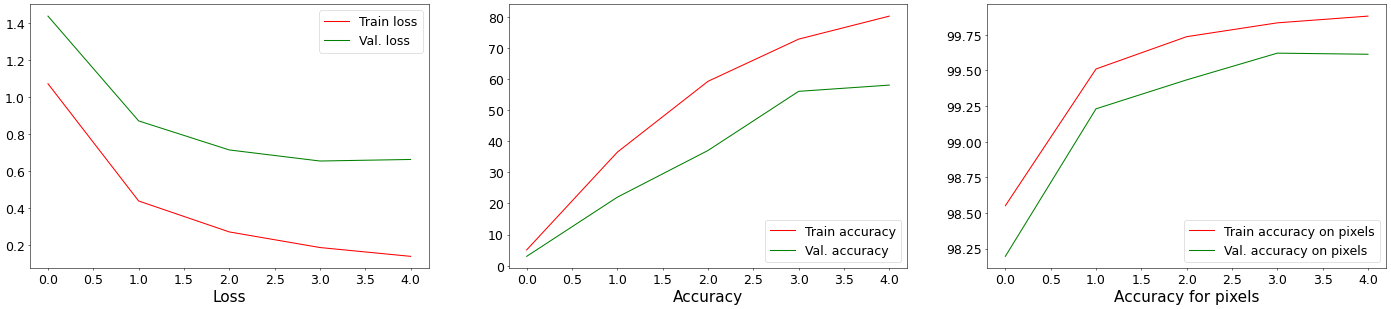

NameError: name 'output' is not defined

In [151]:
# Training
FullyCon_result_T3, FullyCon_predictions_T3, FullyCon_wrong_pred_T3 = evaluate_metrics(TaskSolver(), 
                                                                                        data, 
                                                                                        FullyCon, CrossEntropyLoss, 
                                                                                        n_epoch=5, device=device,
                                                                                        lr = 0.1, verbose=False, attention = False)

save_results(path, [FullyCon_result_T3, FullyCon_predictions_T3, FullyCon_wrong_pred_T3], 
             ['FullyCon_result_T3', 'FullyCon_predictions_T3', 'FullyCon_wrong_pred_T3'])


plot_metrics(load_results(path, 'FullyCon_result_T3'))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

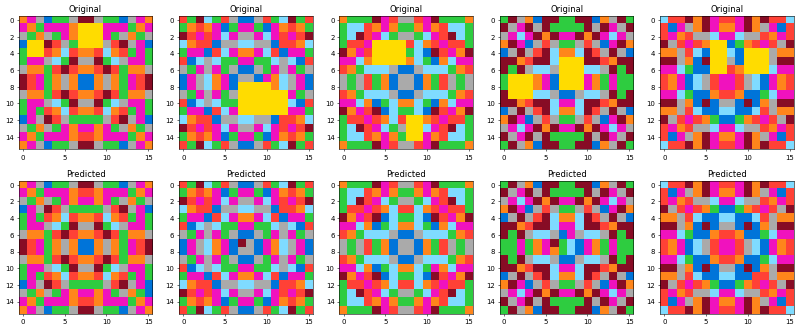

In [152]:
compare_plots(load_results(path, 'FullyCon_wrong_pred_T3'), n=5) # 5 wrong predictions

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [31:04<00:00, 372.99s/it]


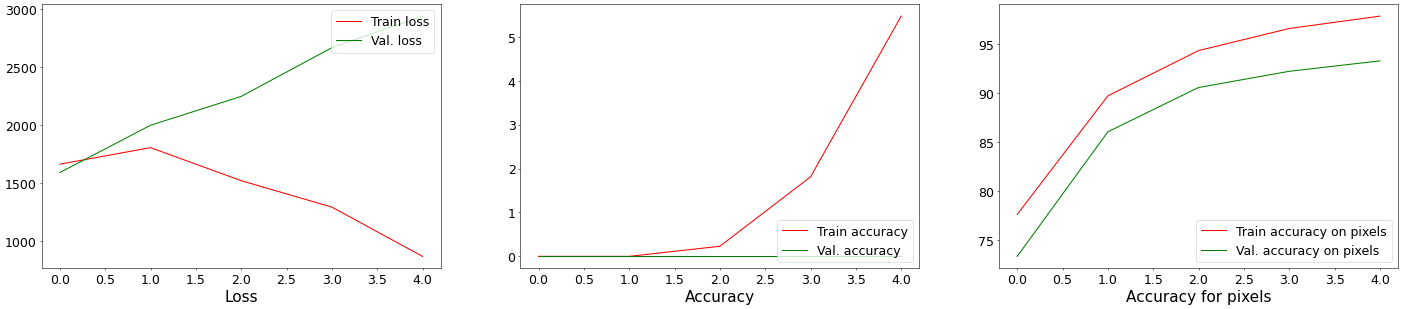

In [153]:
# Training
FullyConDeep_result_T3, FullyConDeep__predictions_T3, FullyConDeep_wrong_pred_T3 = evaluate_metrics(TaskSolver(), 
                                                                                        data, 
                                                                                        FullyCon_deep, CrossEntropyLoss, 
                                                                                        n_epoch=5, device=device,
                                                                                        lr = 0.1, verbose=False, 
                                                                                        attention = False)

save_results(path, [FullyConDeep_result_T3, FullyConDeep__predictions_T3, FullyConDeep_wrong_pred_T3], 
             ['FullyConDeep_result_T3', 'FullyConDeep__predictions_T3', 'FullyConDeep_wrong_pred_T3'])


plot_metrics(load_results(path, 'FullyConDeep_result_T3'))


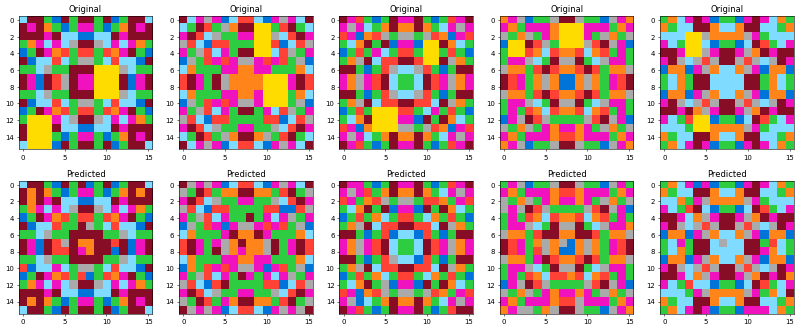

In [154]:
compare_plots(load_results(path, 'FullyConDeep_wrong_pred_T3'), n=5) # 5 wrong predictions

## LSTM

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:33<00:00, 66.67s/it]


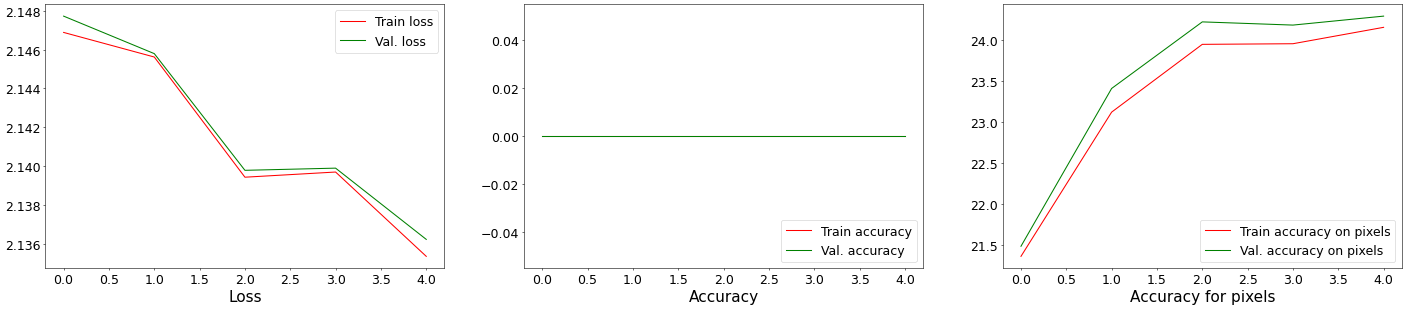

NameError: name 'output' is not defined

In [155]:
# Training with attention
LSTM_result_T3, LSTM_predictions_T3, LSTM_wrong_pred_T3 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            LSTM, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [LSTM_result_T3, LSTM_predictions_T3, LSTM_wrong_pred_T3], 
             ['LSTM_result_T3', 'LSTM_predictions_T3', 'LSTM_wrong_pred_T3'])


plot_metrics(load_results(path, 'LSTM_result_T3'))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

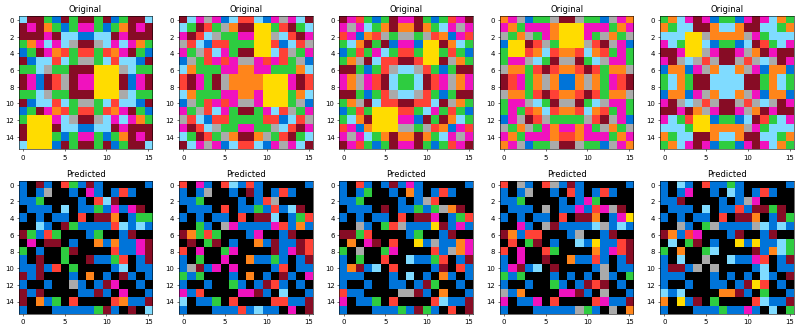

In [156]:
compare_plots(load_results(path, 'LSTM_wrong_pred_T3'), n=5) # 5 wrong predictions

 20%|████████████████▊                                                                   | 1/5 [00:57<03:51, 57.89s/it]


Epoch: [1/5]
Train loss is: 2.193925516653061
Validation loss is: 2.1945464324951174
Train accuracy is: 0.0 %
Train accuracy for pixels is: 15.8637109375 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 15.75 %


 40%|█████████████████████████████████▌                                                  | 2/5 [01:56<02:54, 58.25s/it]


Epoch: [2/5]
Train loss is: 2.1828965712308883
Validation loss is: 2.1832982802391054
Train accuracy is: 0.0 %
Train accuracy for pixels is: 17.7610546875 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 17.74609375 %


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:53<01:55, 57.88s/it]


Epoch: [3/5]
Train loss is: 2.178457315945625
Validation loss is: 2.178385772705078
Train accuracy is: 0.0 %
Train accuracy for pixels is: 18.288984375 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 18.375 %


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:52<00:57, 57.95s/it]


Epoch: [4/5]
Train loss is: 2.175959289574623
Validation loss is: 2.1760872197151184
Train accuracy is: 0.0 %
Train accuracy for pixels is: 19.1200390625 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 19.21875 %


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:49<00:00, 57.93s/it]


Epoch: [5/5]
Train loss is: 2.1747286041736604
Validation loss is: 2.1748887419700624
Train accuracy is: 0.0 %
Train accuracy for pixels is: 19.186015625 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 19.26953125 %


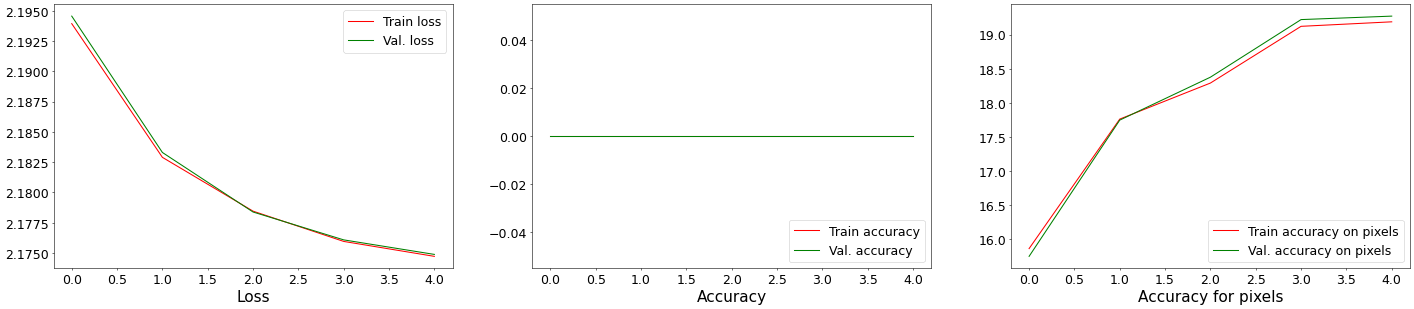

In [157]:
# Training
LSTM_no_result_T3, LSTM_no_predictions_T3, LSTM_no_wrong_pred_T3 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            LSTM, CrossEntropyLoss, 
                                                                            attention = None,
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=True)

save_results(path, [LSTM_no_result_T3, LSTM_no_predictions_T3, LSTM_no_wrong_pred_T3], 
             ['LSTM_no_result_T3', 'LSTM_no_predictions_T3', 'LSTM_no_wrong_pred_T3'])


plot_metrics(load_results(path, 'LSTM_no_result_T3'))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

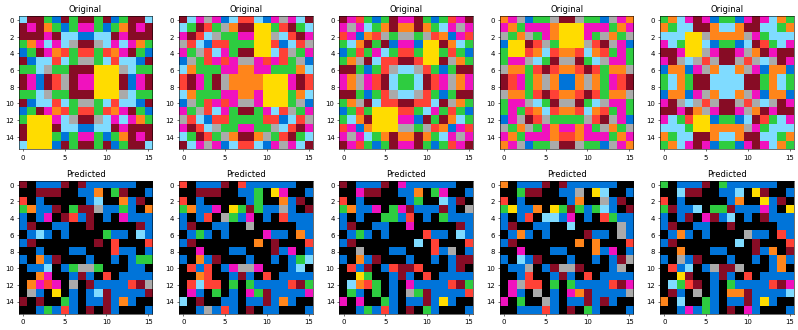

In [158]:
compare_plots(load_results(path, 'LSTM_no_wrong_pred_T3'), n=5) # 5 wrong predictions

## CNN

 20%|████████████████▊                                                                   | 1/5 [00:55<03:42, 55.71s/it]


Epoch: [1/5]
Train loss is: 57.24431488928795
Validation loss is: 60.814020290374756
Train accuracy is: 0.0 %
Train accuracy for pixels is: 94.4965625 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 94.32421875 %


 40%|█████████████████████████████████▌                                                  | 2/5 [01:49<02:45, 55.21s/it]


Epoch: [2/5]
Train loss is: 31.45229461517334
Validation loss is: 34.03133232116699
Train accuracy is: 0.0 %
Train accuracy for pixels is: 94.3683984375 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 94.19140625 %


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:43<01:49, 54.81s/it]


Epoch: [3/5]
Train loss is: 31.274137881422043
Validation loss is: 33.057065172195436
Train accuracy is: 0.0 %
Train accuracy for pixels is: 94.4324609375 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 94.328125 %


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:37<00:54, 54.46s/it]


Epoch: [4/5]
Train loss is: 21.10340744524002
Validation loss is: 21.240902070999145
Train accuracy is: 0.0 %
Train accuracy for pixels is: 94.3626171875 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 94.328125 %


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:31<00:00, 54.30s/it]


Epoch: [5/5]
Train loss is: 10.6757639605999
Validation loss is: 11.212966494560241
Train accuracy is: 0.0 %
Train accuracy for pixels is: 94.1217578125 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 94.19140625 %


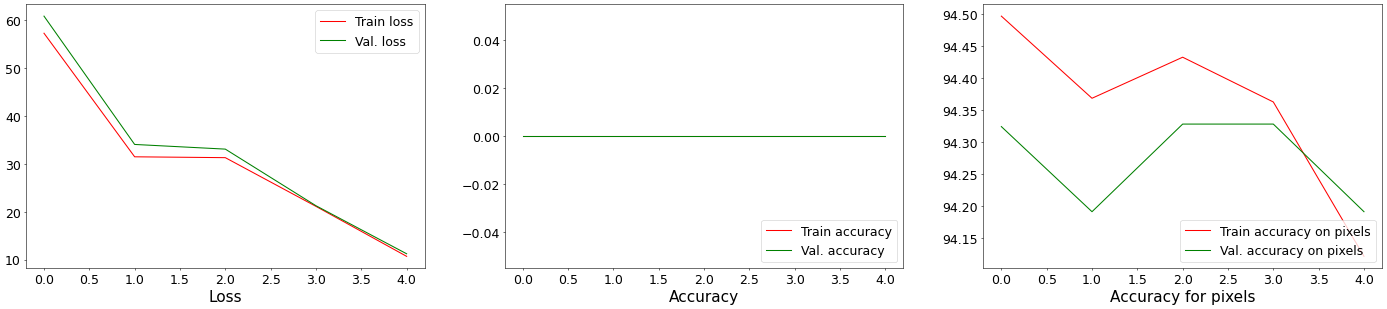

In [159]:
# Training
CNN_result_T3, CNN_predictions_T3, CNN_wrong_pred_T3 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_5, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=True)

save_results(path, [CNN_result_T3, CNN_predictions_T3, CNN_wrong_pred_T3], 
             ['CNN_result_T3', 'CNN_predictions_T3', 'CNN_wrong_pred_T3'])


plot_metrics(load_results(path, 'CNN_result_T3'))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

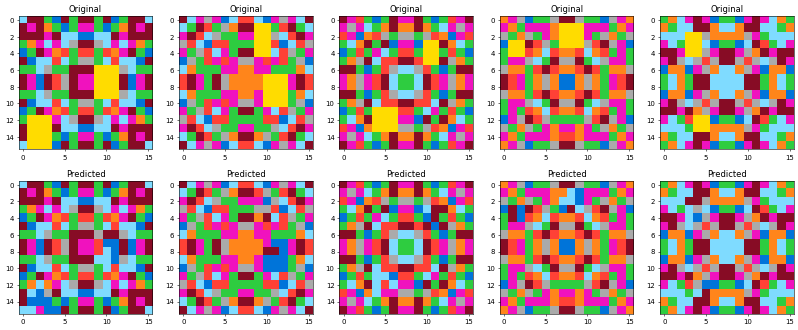

In [160]:
compare_plots(load_results(path, 'CNN_wrong_pred_T3'), n=5) # 5 wrong predictions

 20%|████████████████▊                                                                   | 1/5 [00:45<03:00, 45.20s/it]


Epoch: [1/5]
Train loss is: 23.24732219004631
Validation loss is: 24.231526041030882
Train accuracy is: 0.0 %
Train accuracy for pixels is: 94.2116015625 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 94.11328125 %


 40%|█████████████████████████████████▌                                                  | 2/5 [01:29<02:14, 44.97s/it]


Epoch: [2/5]
Train loss is: 27.125908901929854
Validation loss is: 28.419785223007203
Train accuracy is: 0.0 %
Train accuracy for pixels is: 94.38546875 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 94.34765625 %


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:13<01:29, 44.79s/it]


Epoch: [3/5]
Train loss is: 17.38725762248039
Validation loss is: 17.967292375564575
Train accuracy is: 0.0 %
Train accuracy for pixels is: 94.3634765625 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 94.30078125 %


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:58<00:44, 44.85s/it]


Epoch: [4/5]
Train loss is: 17.84266173918247
Validation loss is: 18.378580026626587
Train accuracy is: 0.0 %
Train accuracy for pixels is: 94.3533203125 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 94.3828125 %


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:43<00:00, 44.78s/it]


Epoch: [5/5]
Train loss is: 54.55448609991073
Validation loss is: 56.979163608551026
Train accuracy is: 0.0 %
Train accuracy for pixels is: 94.4691796875 %
Validation accuracy is: 0.0 %
Validation accuracy for pixels is: 94.40234375 %


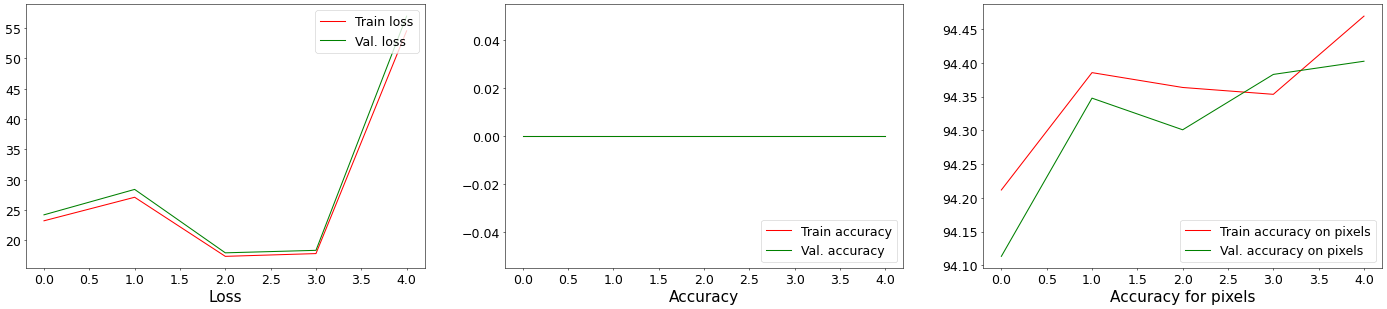

In [161]:
# Training
CNN_no_result_T3, CNN_no_predictions_T3, CNN_no_wrong_pred_T3 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_5, CrossEntropyLoss, 
                                                                            attention = None,
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=True)

save_results(path, [CNN_no_result_T3, CNN_no_predictions_T3, CNN_no_wrong_pred_T3], 
             ['CNN_no_result_T3', 'CNN_no_predictions_T3', 'CNN_no_wrong_pred_T3'])


plot_metrics(load_results(path, 'CNN_no_result_T3'))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

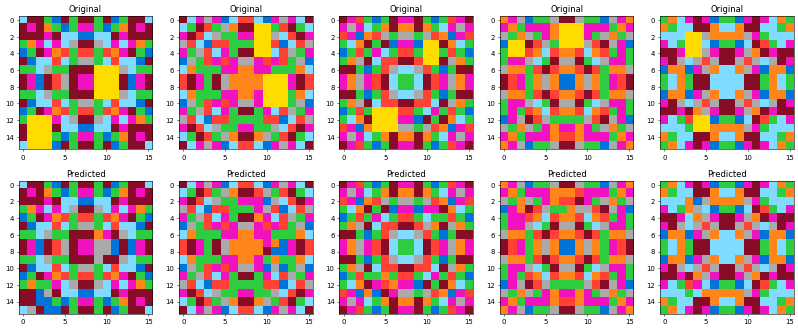

In [162]:
compare_plots(load_results(path, 'CNN_no_wrong_pred_T3'), n=5) # 5 wrong predictions

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:33<00:00, 54.72s/it]


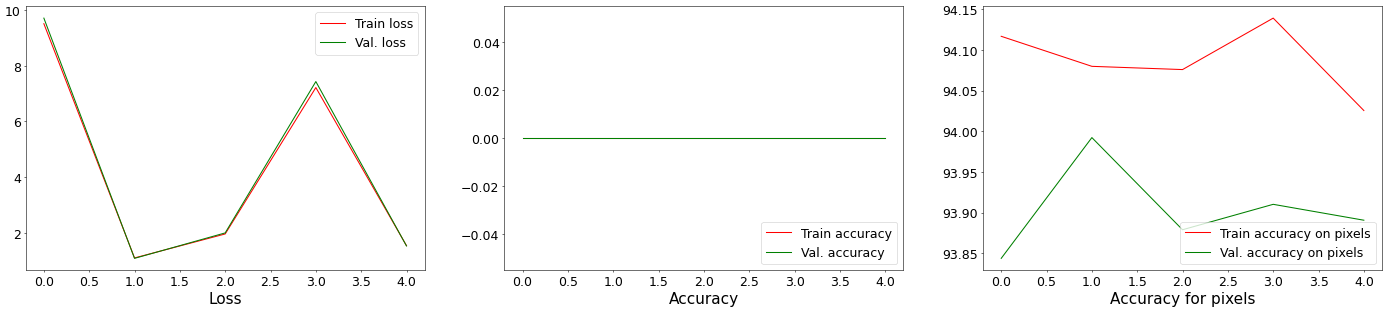

In [31]:
# Training
CNN3_result_T3, CNN3_predictions_T3, CNN3_wrong_pred_T3 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_3, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [CNN3_result_T3, CNN3_predictions_T3, CNN3_wrong_pred_T3], 
             ['CNN3_result_T3', 'CNN3_predictions_T3', 'CNN3_wrong_pred_T3'])


plot_metrics(load_results(path, 'CNN3_result_T3'))

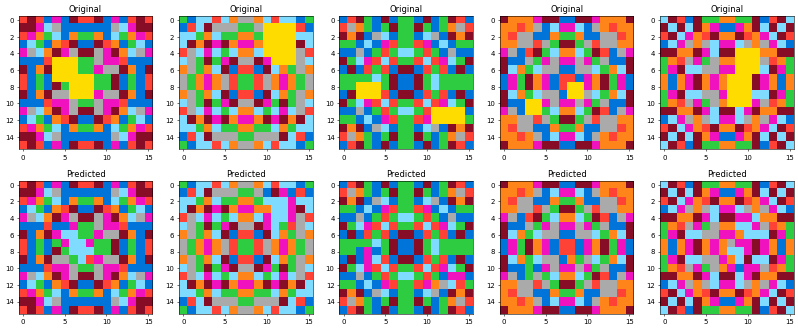

In [32]:
compare_plots(load_results(path, 'CNN3_wrong_pred_T3'), n=5) # 5 wrong predictions

### GRU

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]src\models.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = F.softmax(att)
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:17<00:00, 63.45s/it]
C:\Users\Egon\Anaconda3\envs\pytorch\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


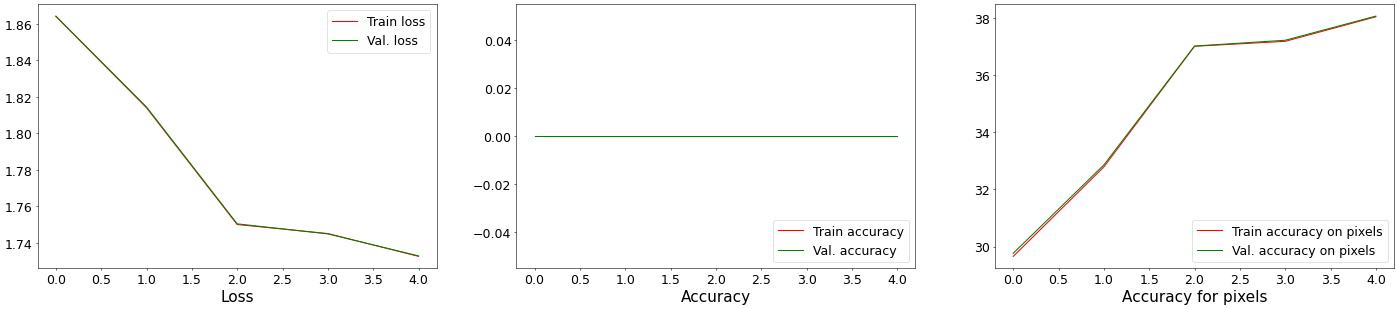

In [66]:
# Training with attention
GRU_result_T2, GRU_predictions_T2, GRU_wrong_pred_T2 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            GRU, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [GRU_result_T2, GRU_predictions_T2, GRU_wrong_pred_T2], 
             ['GRU_result_T2', 'GRU_predictions_T2', 'GRU_wrong_pred_T2'])

plot_metrics(load_results(path, 'GRU_result_T2'))

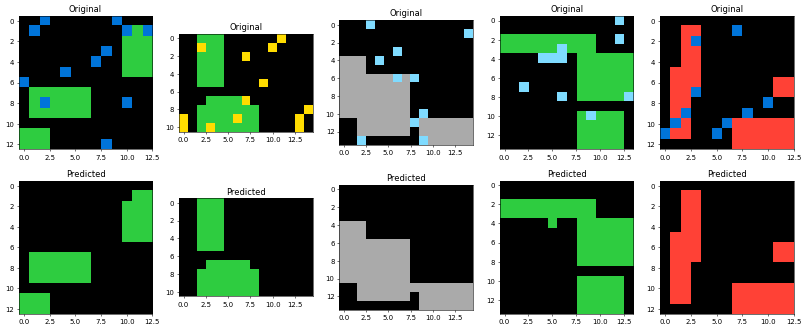

In [67]:
compare_plots(load_results(path, 'CNN3_wrong_pred_T4'), n=5) # 5 wrong predictions

# Task 4

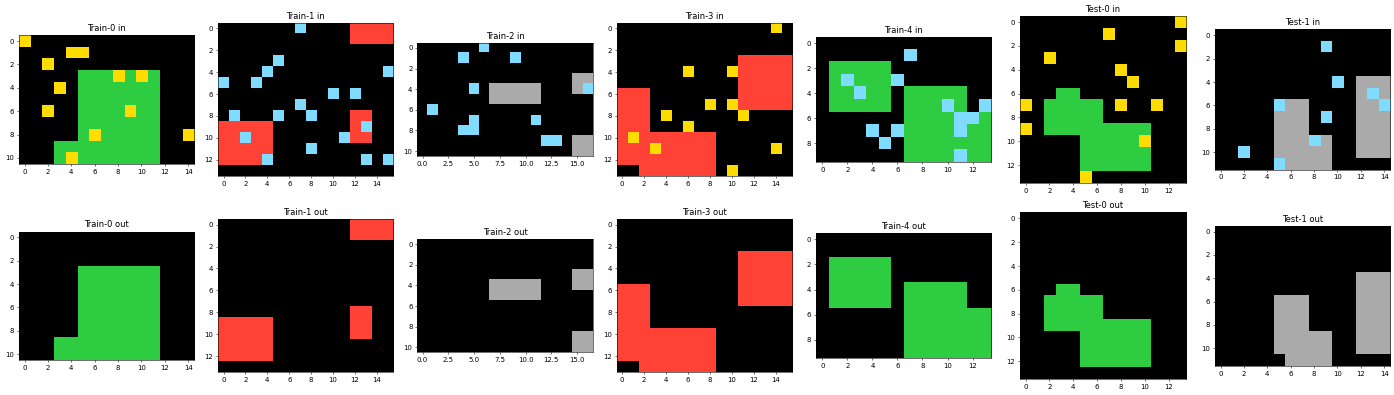

In [33]:
task=task_builder(gener_four, 5, 2)
plot_task(task)


In [34]:
data=[task_builder(gener_four, 10000, 100)]

## FCN

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [14:56<00:00, 179.34s/it]
C:\Users\Egon\Anaconda3\envs\pytorch\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


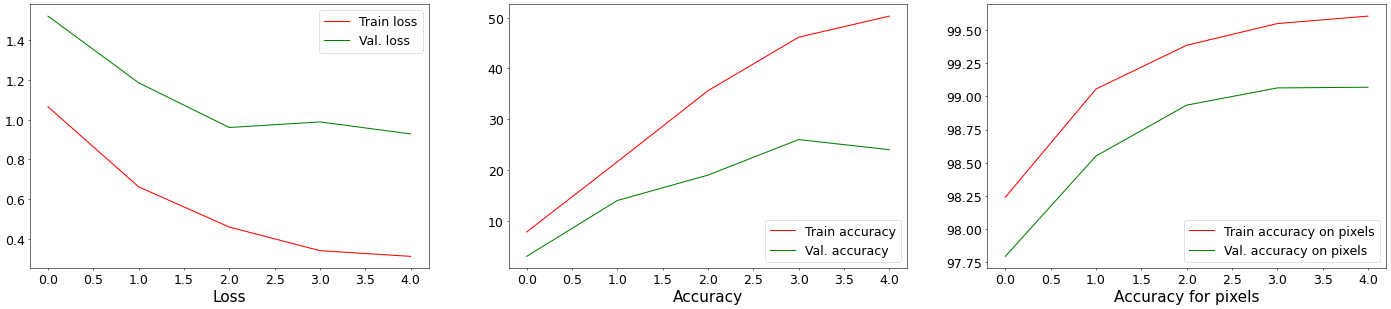

In [11]:
# Training
FullyCon_result_T4, FullyCon_predictions_T4, FullyCon_wrong_pred_T4 = evaluate_metrics(TaskSolver(), 
                                                                                        data, 
                                                                                        FullyCon_T4, CrossEntropyLoss, 
                                                                                        n_epoch=5, device=device,
                                                                                        lr = 0.1, verbose=False)

save_results(path, [FullyCon_result_T4, FullyCon_predictions_T4, FullyCon_wrong_pred_T4 ], 
             ['FullyCon_result_T4', 'FullyCon_predictions_T4', 'FullyCon_wrong_pred_T4' ])


plot_metrics(load_results(path, 'FullyCon_result_T4'))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

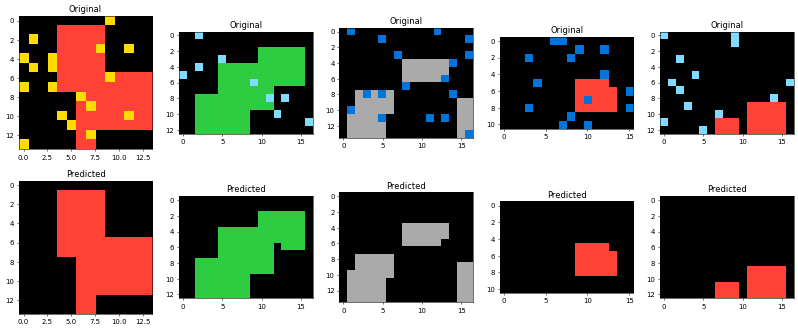

In [13]:
compare_plots(load_results(path, 'FullyCon_predictions_T4'), n=5) # 5 wrong predictions

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [28:19<00:00, 339.97s/it]


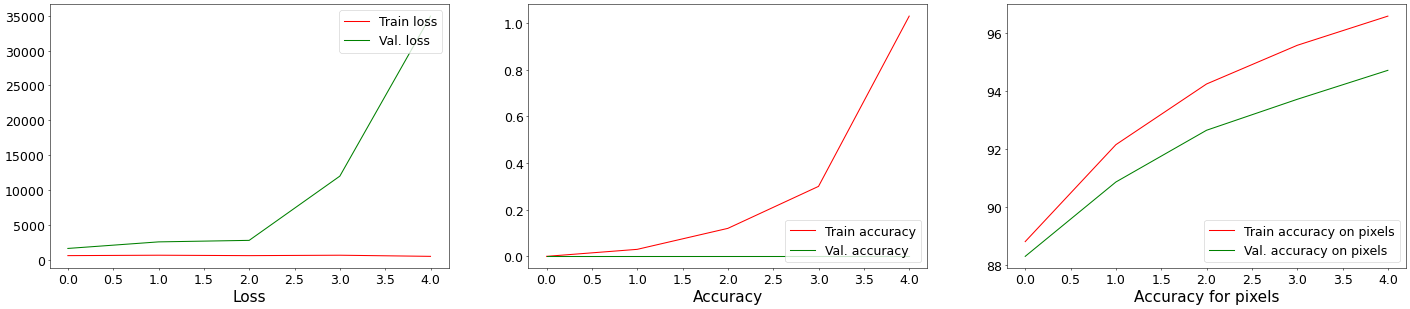

In [35]:
# Training
FullyConDeep_result_T4, FullyConDeep_predictions_T4, FullyConDeep_wrong_pred_T4 = evaluate_metrics(TaskSolver(), 
                                                                                        data, 
                                                                                        FullyCon_deep_T4, CrossEntropyLoss, 
                                                                                        n_epoch=5, device=device,
                                                                                        lr = 0.1, verbose=False)

save_results(path, [FullyConDeep_result_T4, FullyConDeep_predictions_T4, FullyConDeep_wrong_pred_T4 ], 
             ['FullyConDeep_result_T4', 'FullyConDeep_predictions_T4', 'FullyConDeep_wrong_pred_T4' ])


plot_metrics(load_results(path, 'FullyConDeep_result_T4'))

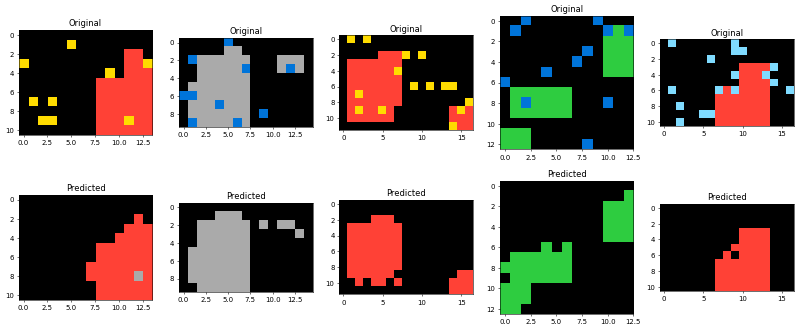

In [37]:
compare_plots(load_results(path, 'FullyConDeep_predictions_T4'), n=5) # 5 wrong predictions

## LSTM

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:13<00:00, 74.68s/it]


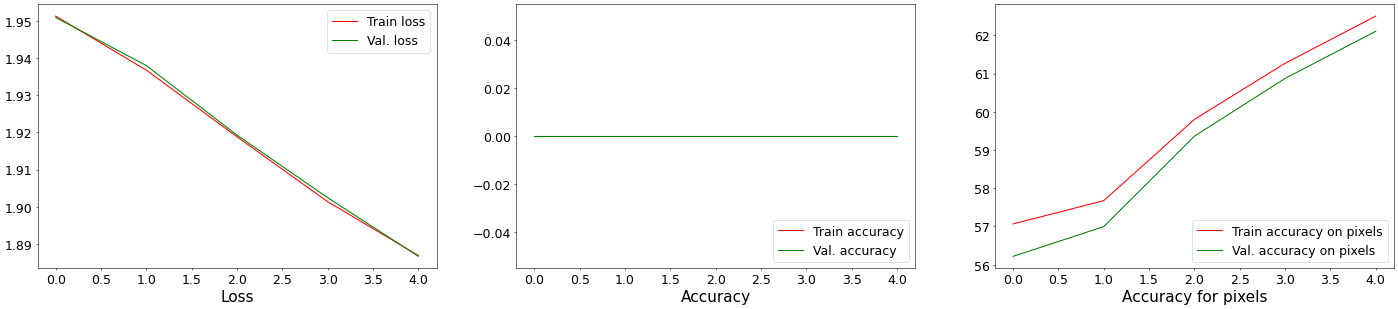

NameError: name 'output' is not defined

In [38]:
# Training with attention
LSTM_result_T4, LSTM_predictions_T4, LSTM_wrong_pred_T4 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            LSTM_T4, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [LSTM_result_T4, LSTM_predictions_T4, LSTM_wrong_pred_T4], 
             ['LSTM_result_T4', 'LSTM_predictions_T4', 'LSTM_wrong_pred_T4'])


plot_metrics(load_results(path, 'LSTM_result_T4'))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

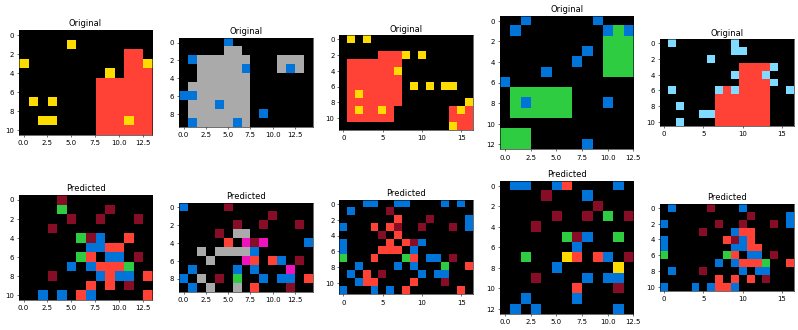

In [39]:
compare_plots(load_results(path, 'LSTM_wrong_pred_T4'), n=5) # 5 wrong predictions

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:31<00:00, 66.21s/it]


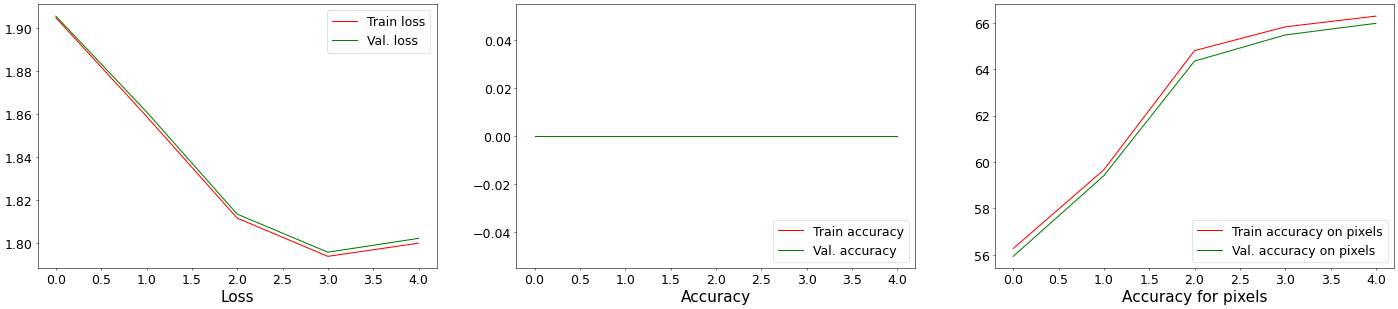

In [40]:
# Training without attention
LSTM_no_result_T4, LSTM_no_predictions_T4, LSTM_no_wrong_pred_T4 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            LSTM_T4, CrossEntropyLoss, 
                                                                            attention = None,
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [LSTM_no_result_T4, LSTM_no_predictions_T4, LSTM_no_wrong_pred_T4], 
             ['LSTM_no_result_T4', 'LSTM_no_predictions_T4', 'LSTM_no_wrong_pred_T4'])


plot_metrics(load_results(path, 'LSTM_no_result_T4'))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

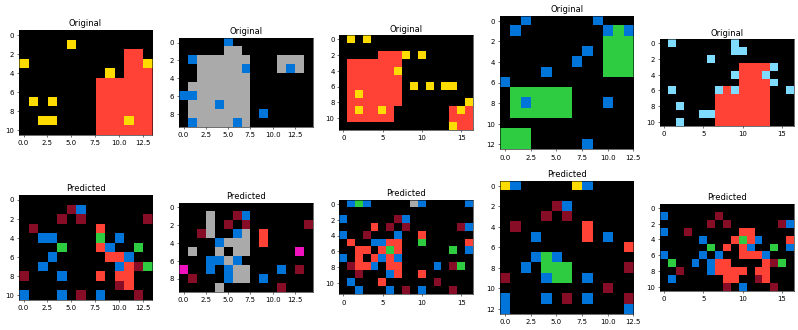

In [41]:
compare_plots(load_results(path, 'LSTM_no_wrong_pred_T4'), n=5) # 5 wrong predictions

## CNN

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:29<00:00, 53.98s/it]


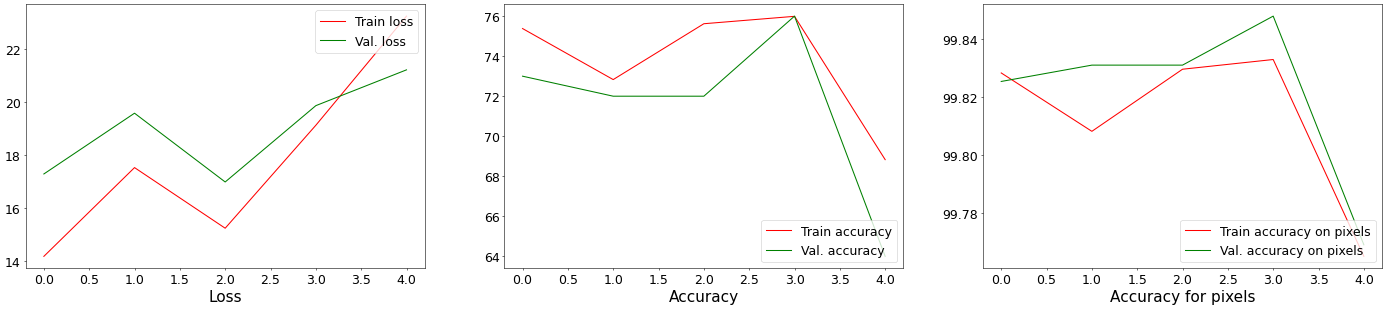

In [46]:
# Training with attention
CNN_result_T4, CNN_predictions_T4, CNN_wrong_pred_T4 = evaluate_metrics(TaskSolver(), 
                                                                        data, 
                                                                        CNN_5, CrossEntropyLoss, 
                                                                        attention = 'yes',
                                                                        n_epoch=5, device=device,
                                                                        lr = 0.1, verbose=False)

save_results(path, [CNN_result_T4, CNN_predictions_T4, CNN_wrong_pred_T4], 
             ['CNN_result_T4', 'CNN_predictions_T4', 'CNN_wrong_pred_T4'])


plot_metrics(load_results(path, 'CNN_result_T4'))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

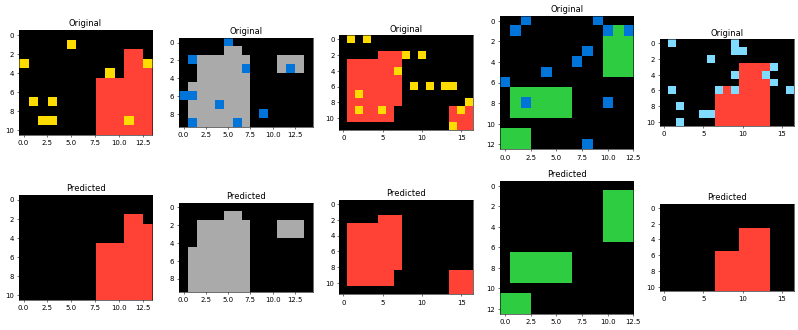

In [48]:
compare_plots(load_results(path, 'CNN_predictions_T4'), n=5) # 5 wrong predictions

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:40<00:00, 44.07s/it]


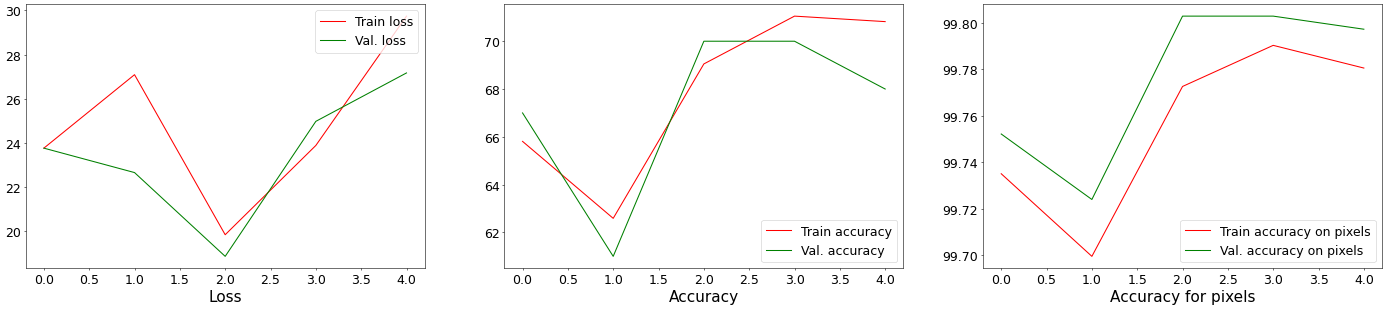

In [50]:
# Training
CNN_no_result_T4, CNN_no_predictions_T4, CNN_no_wrong_pred_T4 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_5, CrossEntropyLoss, 
                                                                            attention = None,
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [CNN_no_result_T4, CNN_no_predictions_T4, CNN_no_wrong_pred_T4], 
             ['CNN_no_result_T4', 'CNN_no_predictions_T4', 'CNN_no_wrong_pred_T4'])

plot_metrics(load_results(path, 'CNN_no_result_T4'))

#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

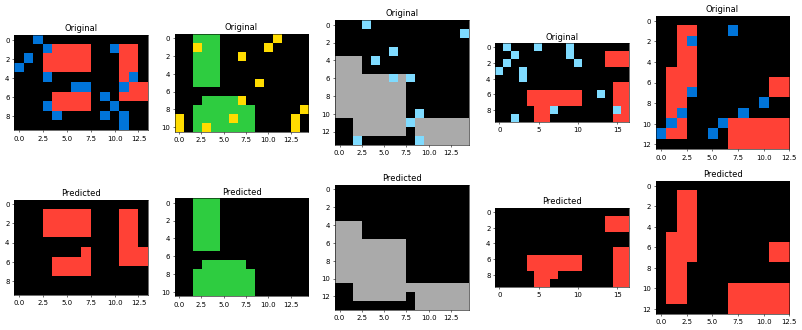

In [51]:
compare_plots(load_results(path, 'CNN_no_wrong_pred_T4'), n=5) # 5 wrong predictions

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:43<00:00, 56.69s/it]


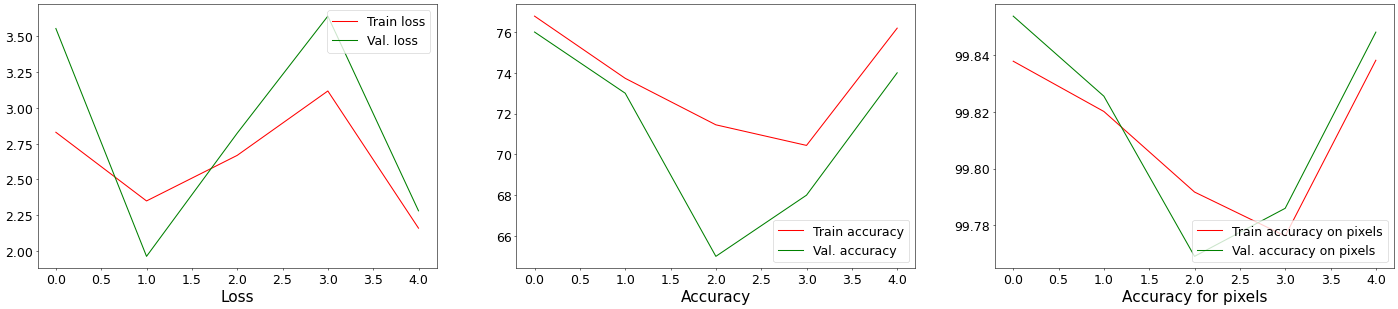

In [52]:
# Training
CNN3_result_T4, CNN3_predictions_T4, CNN3_wrong_pred_T4 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_3, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [CNN3_result_T4, CNN3_predictions_T4, CNN3_wrong_pred_T4], 
             ['CNN3_result_T4', 'CNN3_predictions_T4', 'CNN3_wrong_pred_T4'])


plot_metrics(load_results(path, 'CNN3_result_T4'))

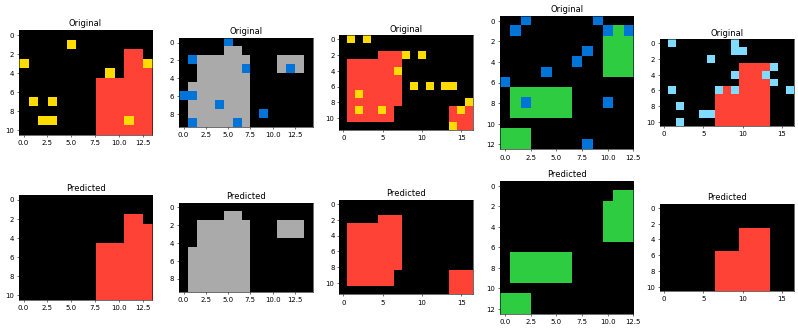

In [53]:
compare_plots(load_results(path, 'CNN3_predictions_T4'), n=5) # 5 wrong predictions

### GRU

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]src\models.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = F.softmax(att)
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:43<00:00, 68.68s/it]
C:\Users\Egon\Anaconda3\envs\pytorch\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


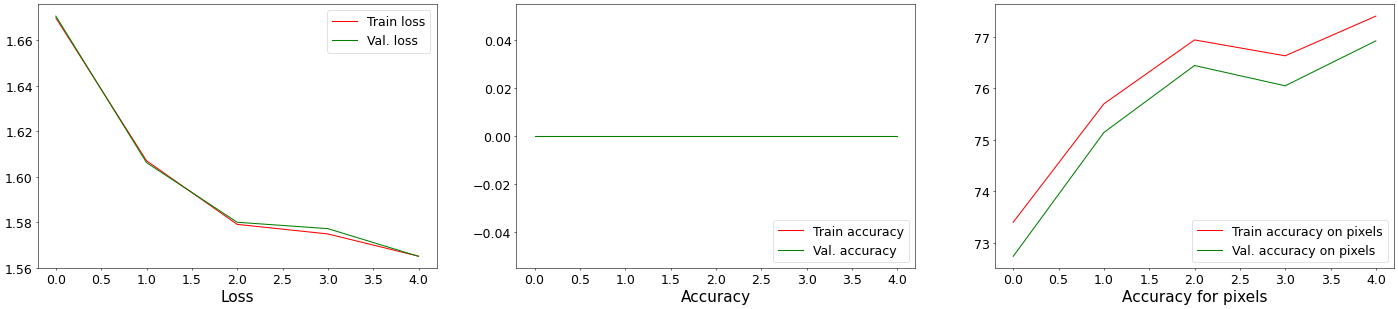

In [56]:
# Training with attention
GRU_result_T4, GRU_predictions_T4, GRU_wrong_pred_T4 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            GRU_T4, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [GRU_result_T4, GRU_predictions_T4, GRU_wrong_pred_T4], 
             ['GRU_result_T4', 'GRU_predictions_T4', 'GRU_wrong_pred_T4'])

plot_metrics(load_results(path, 'GRU_result_T4'))

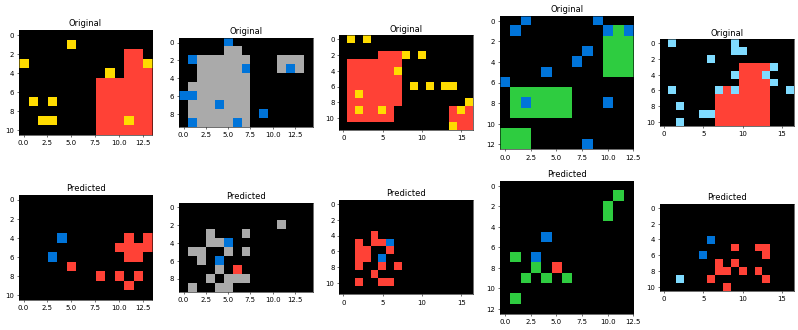

In [57]:
compare_plots(load_results(path, 'GRU_predictions_T4'), n=5) # 5 wrong predictions

# Task 5

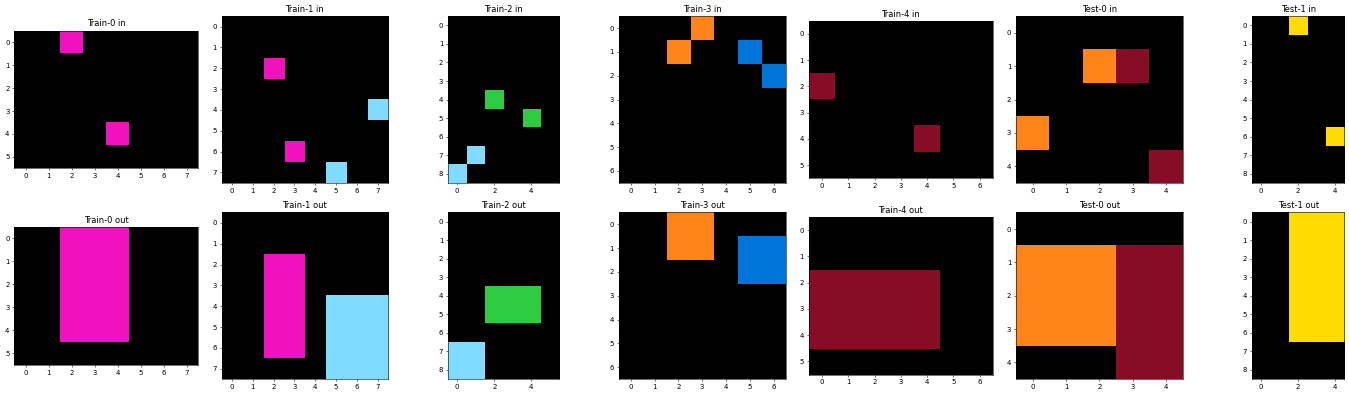

In [68]:
task=task_builder(gener_five, 5, 2)
plot_task(task)
# input.shape == output.shape and inputs have same shape between each others

In [69]:
data=[task_builder(gener_five, 10000, 100)]

### FCNN

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:47<00:00, 57.45s/it]


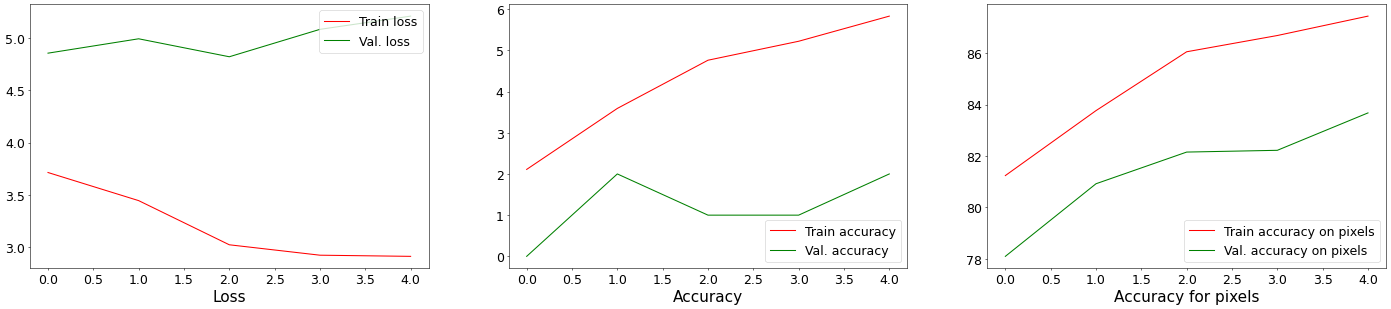

In [70]:
# Training
FullyCon_result_T5, FullyCon_predictions_T5, FullyCon_wrong_pred_T5 = evaluate_metrics(TaskSolver(), 
                                                                                        data, 
                                                                                        FullyCon_T4, CrossEntropyLoss, 
                                                                                        n_epoch=5, device=device,
                                                                                        lr = 0.1, verbose=False)

save_results(path, [FullyCon_result_T5, FullyCon_predictions_T5, FullyCon_wrong_pred_T5 ], 
             ['FullyCon_result_T5', 'FullyCon_predictions_T5', 'FullyCon_wrong_pred_T5' ])


plot_metrics(load_results(path, 'FullyCon_result_T5'))


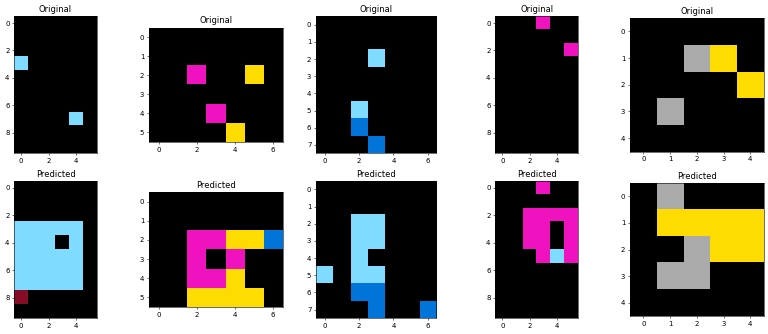

In [71]:
compare_plots(load_results(path, 'FullyCon_wrong_pred_T5'), n=5) # 5 wrong predictions

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:05<00:00, 85.09s/it]
C:\Users\Egon\Anaconda3\envs\pytorch\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


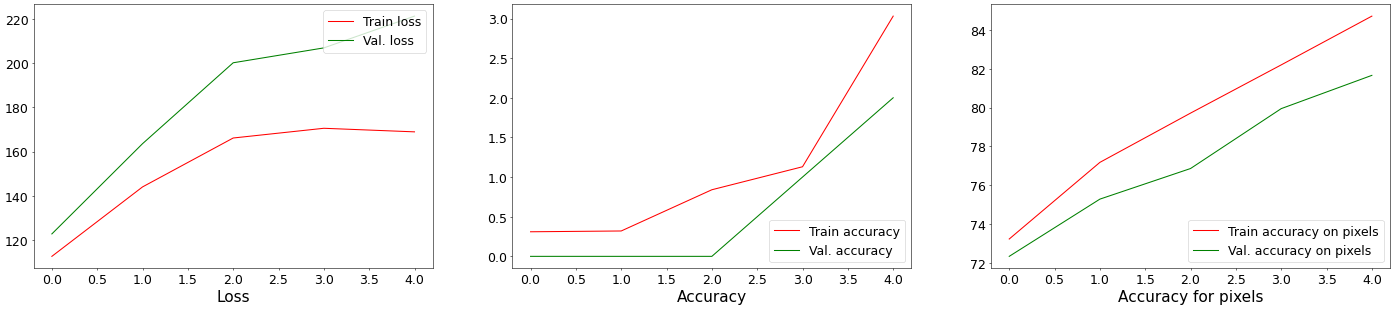

In [72]:
# Training
FullyConDeep_result_T5, FullyConDeep__predictions_T5, FullyConDeep_wrong_pred_T5 = evaluate_metrics(TaskSolver(), 
                                                                                        data, 
                                                                                        FullyCon_deep_T4, CrossEntropyLoss, 
                                                                                        n_epoch=5, device=device,
                                                                                        lr = 0.1, verbose=False, 
                                                                                        attention = False)

save_results(path, [FullyConDeep_result_T5, FullyConDeep__predictions_T5, FullyConDeep_wrong_pred_T5], 
             ['FullyConDeep_result_T5', 'FullyConDeep__predictions_T5', 'FullyConDeep_wrong_pred_T5'])


plot_metrics(load_results(path, 'FullyConDeep_result_T5'))

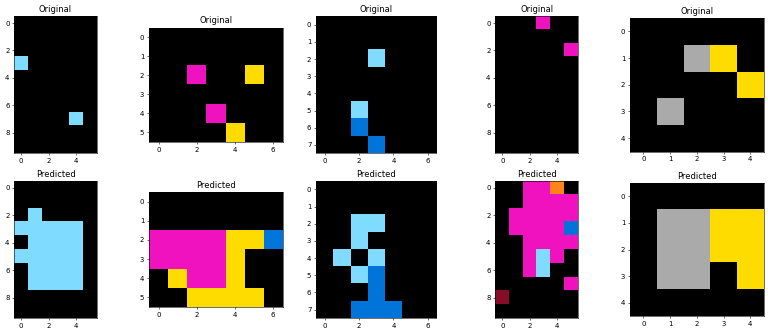

In [73]:
compare_plots(load_results(path, 'FullyConDeep_wrong_pred_T5'), n=5) # 5 wrong predictions

### CNN

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]src\models.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = F.softmax(att)
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:39<00:00, 55.83s/it]


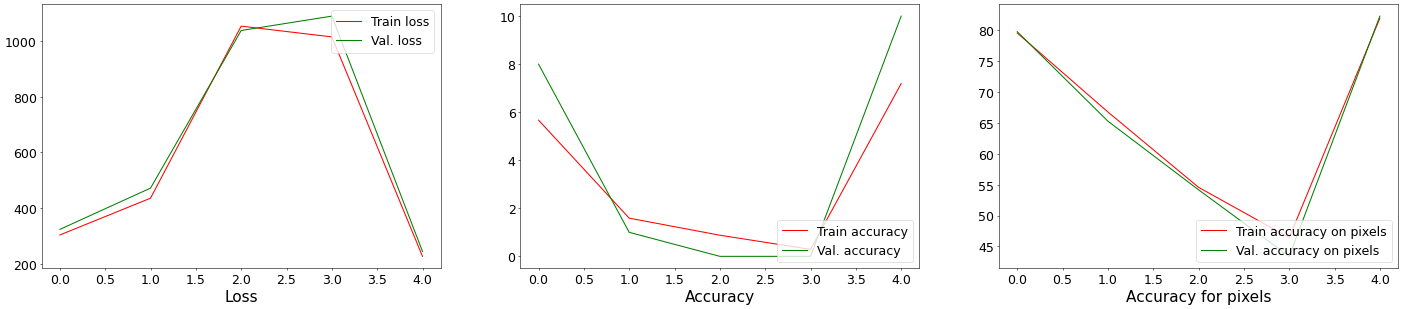

In [74]:
CNN_result_T5, CNN_predictions_T5, CNN_wrong_pred_T5 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_5, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [CNN_result_T5, CNN_predictions_T5, CNN_wrong_pred_T5], 
             ['CNN_result_T5', 'CNN_predictions_T5', 'CNN_wrong_pred_T5'])


plot_metrics(load_results(path,'CNN_result_T5'))

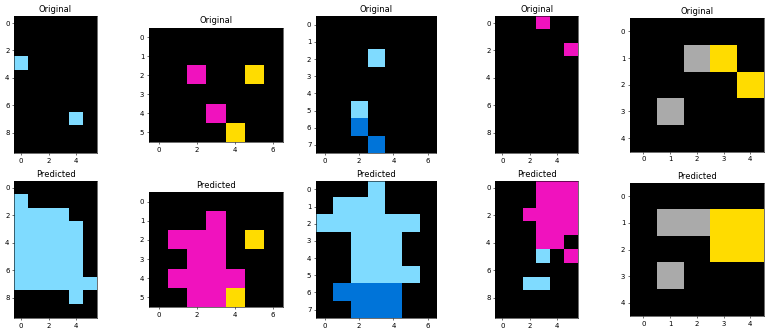

In [75]:
compare_plots(load_results(path, 'CNN_wrong_pred_T5'), n=5) # 5 wrong predictions

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:41<00:00, 56.33s/it]


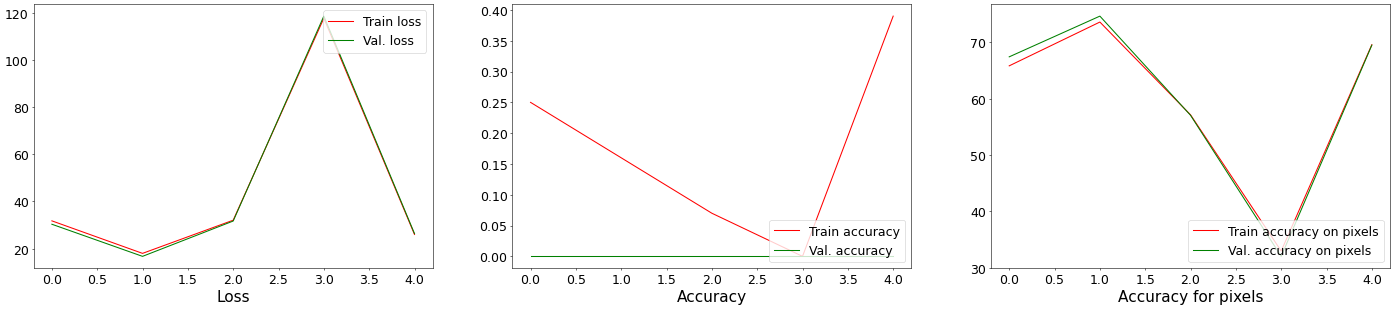

In [76]:
CNN3_result_T5, CNN3_predictions_T5, CNN3_wrong_pred_T5 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_3, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [CNN3_result_T5, CNN3_predictions_T5, CNN3_wrong_pred_T5], 
             ['CNN3_result_T5', 'CNN3_predictions_T5', 'CNN3_wrong_pred_T5'])


plot_metrics(load_results(path,'CNN3_result_T5'))

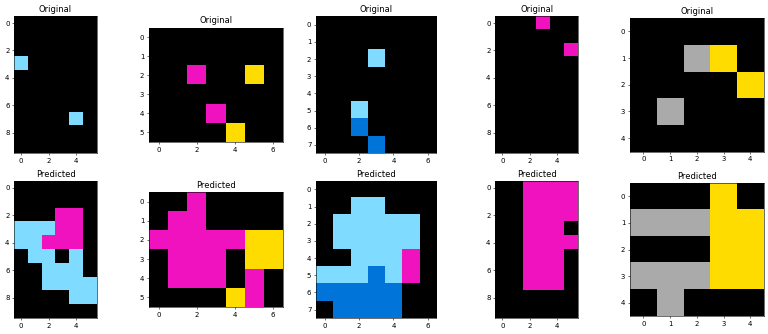

In [77]:
compare_plots(load_results(path, 'CNN3_wrong_pred_T5'), n=5) # 5 wrong predictions

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:50<00:00, 46.04s/it]


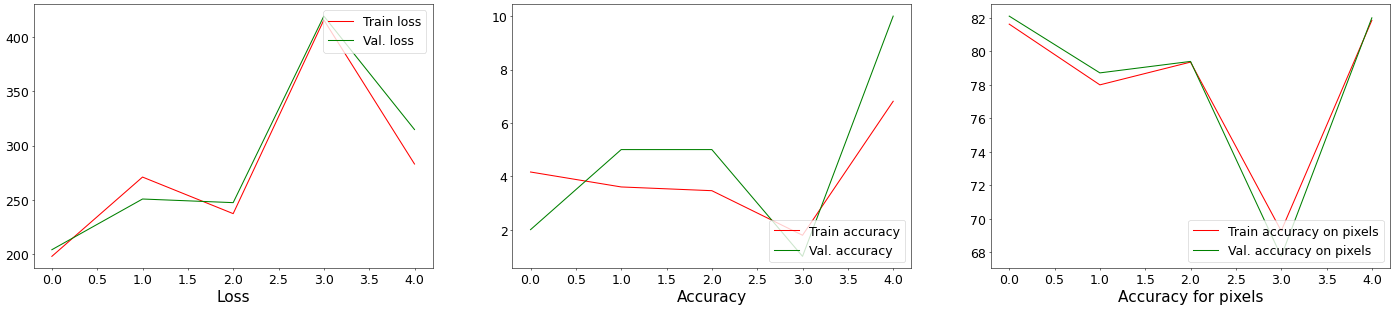

In [78]:
CNN_no_result_T5, CNN_no_predictions_T5, CNN_no_wrong_pred_T5 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_5, CrossEntropyLoss, 
                                                                            attention = None,
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [CNN_no_result_T5, CNN_no_predictions_T5, CNN_no_wrong_pred_T5], 
             ['CNN_no_result_T5', 'CNN_no_predictions_T5', 'CNN_no_wrong_pred_T5'])


plot_metrics(load_results(path,'CNN_no_result_T5'))

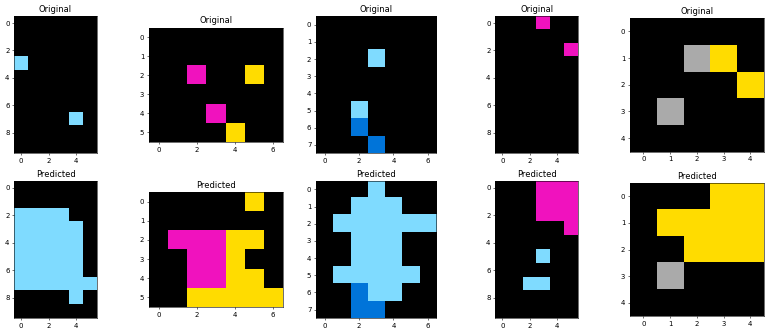

In [79]:
compare_plots(load_results(path, 'CNN_no_wrong_pred_T5'), n=5) # 5 wrong predictions

### LSTM

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:51<00:00, 70.37s/it]


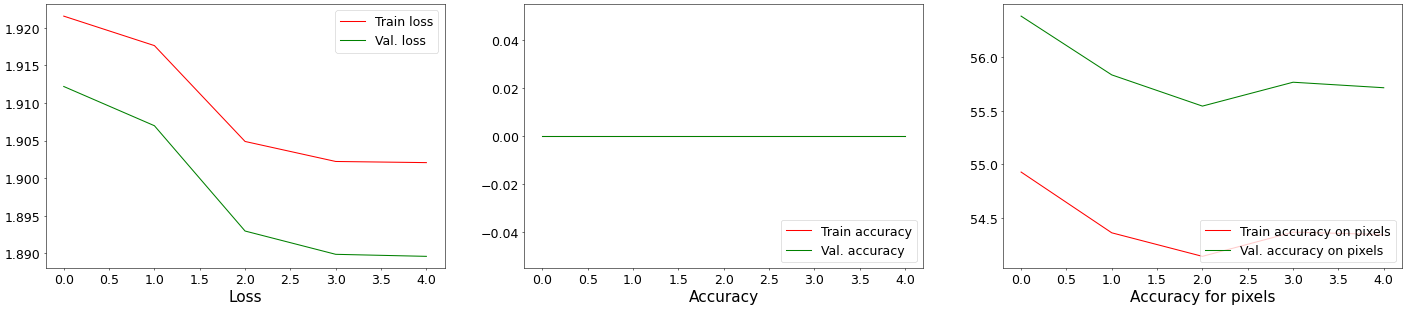

In [80]:
# Training with attention
LSTM_result_T5, LSTM_predictions_T5, LSTM_wrong_pred_T5 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            LSTM_T4, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [LSTM_result_T5, LSTM_predictions_T5, LSTM_wrong_pred_T5], 
             ['LSTM_result_T5', 'LSTM_predictions_T5', 'LSTM_wrong_pred_T5'])


plot_metrics(load_results(path, 'LSTM_result_T5'))


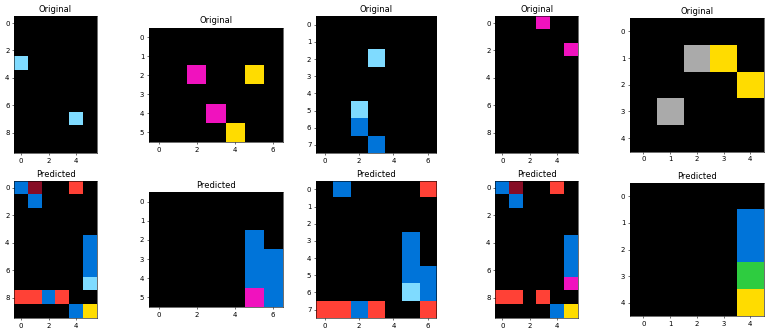

In [81]:
compare_plots(load_results(path, 'LSTM_wrong_pred_T5'), n=5) # 5 wrong predictions

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:45<00:00, 57.18s/it]


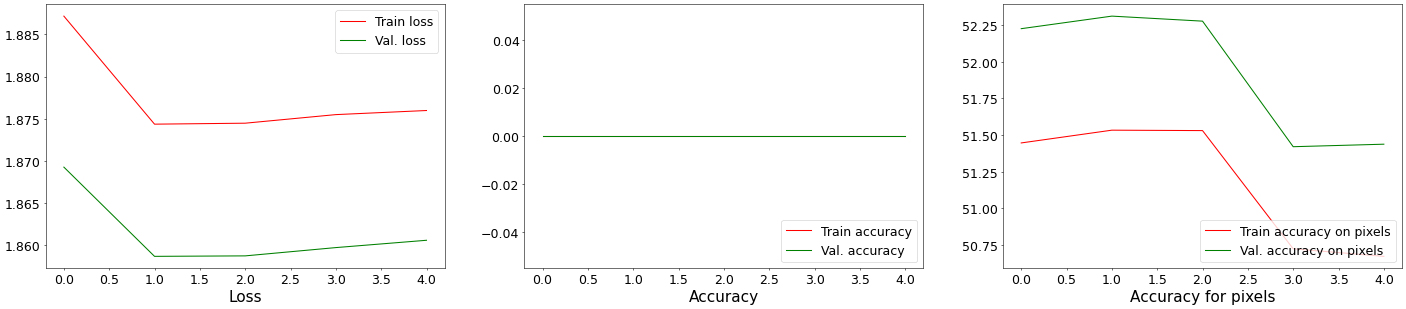

In [82]:
# Training 
LSTM_no_result_T5, LSTM_no_predictions_T5, LSTM_no_wrong_pred_T5 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            LSTM_T4, CrossEntropyLoss, 
                                                                            attention = None,
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [LSTM_no_result_T5, LSTM_no_predictions_T5, LSTM_no_wrong_pred_T5], 
             ['LSTM_no_result_T5', 'LSTM_no_predictions_T5', 'LSTM_no_wrong_pred_T5'])


plot_metrics(load_results(path, 'LSTM_no_result_T5'))


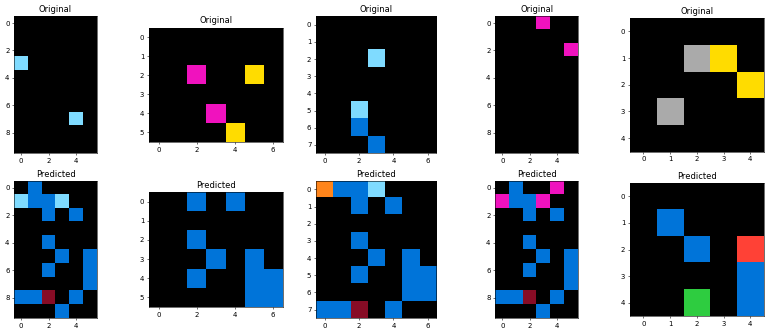

In [83]:
compare_plots(load_results(path, 'LSTM_no_wrong_pred_T5'), n=5) # 5 wrong predictions

### GRU

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:29<00:00, 65.91s/it]


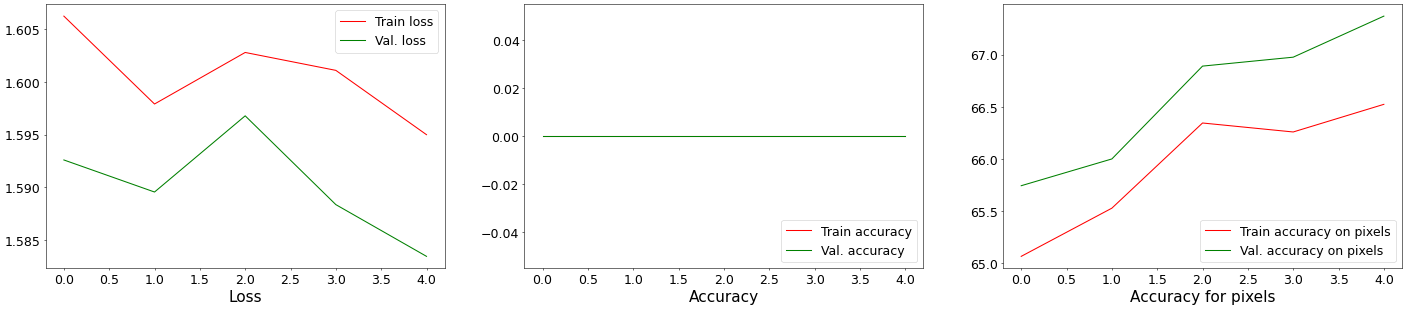

In [84]:
# Training with attention
GRU_result_T5, GRU_predictions_T5, GRU_wrong_pred_T5 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            GRU_T4, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [GRU_result_T5, GRU_predictions_T5, GRU_wrong_pred_T5], 
             ['GRU_result_T5', 'GRU_predictions_T5', 'GRU_wrong_pred_T5'])


plot_metrics(load_results(path, 'GRU_result_T5'))


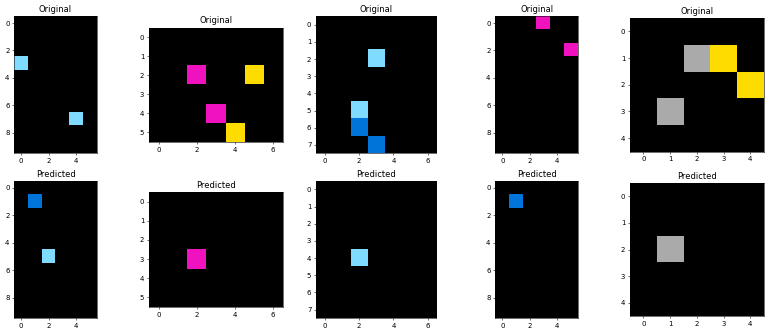

In [85]:
compare_plots(load_results(path, 'GRU_wrong_pred_T5'), n=5) # 5 wrong predictions

# Task 7

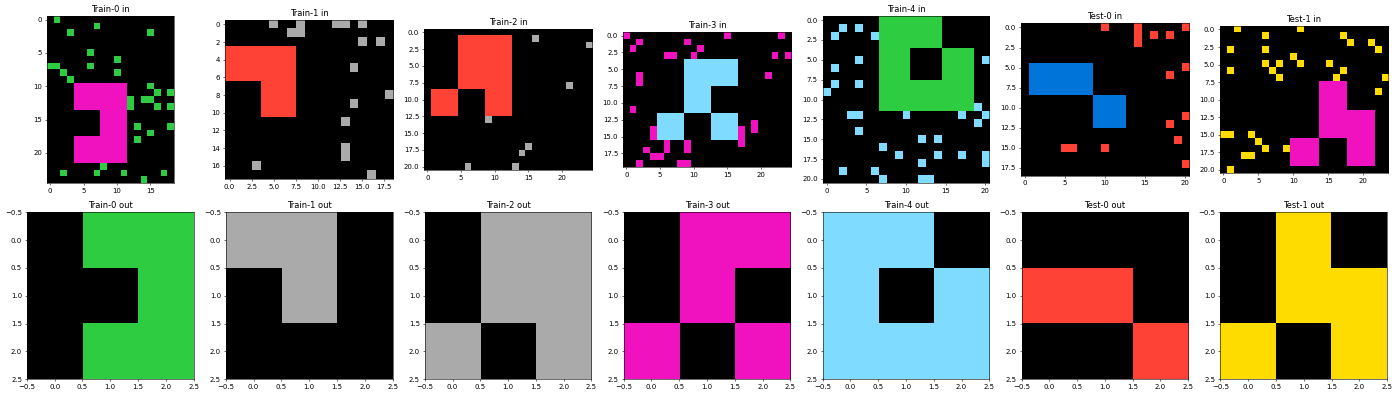

In [86]:
task=task_builder(gener_seven, 5, 2)
plot_task(task)

In [87]:
data=[task_builder(gener_seven, 10000, 100)]

### FCNN

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:12<00:00, 38.54s/it]


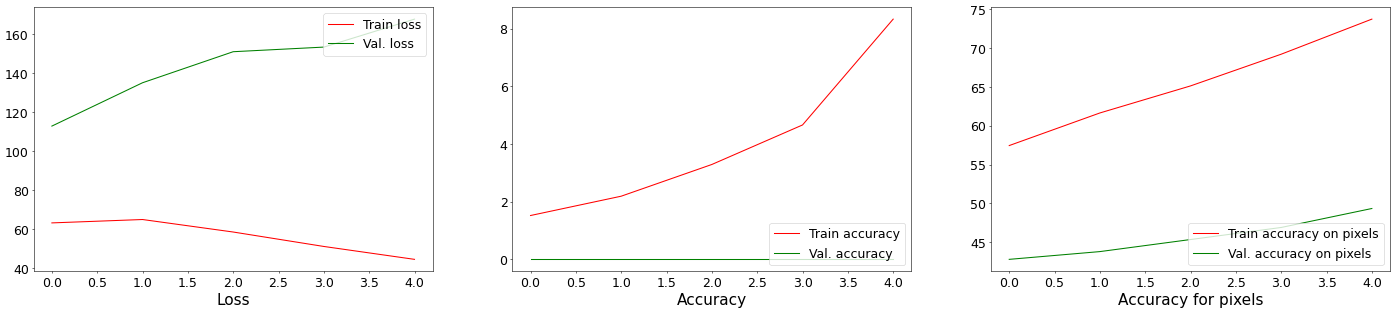

In [88]:
# Training
FullyCon_result_T7, FullyCon_predictions_T7, FullyCon_wrong_pred_T7 = evaluate_metrics(TaskSolver(), 
                                                                                        data, 
                                                                                        FullyCon_T7, CrossEntropyLoss, 
                                                                                        n_epoch=5, device=device,
                                                                                        lr = 0.1, verbose=False)

save_results(path, [FullyCon_result_T7, FullyCon_predictions_T7, FullyCon_wrong_pred_T7 ], 
             ['FullyCon_result_T7', 'FullyCon_predictions_T7', 'FullyCon_wrong_pred_T7' ])


plot_metrics(load_results(path, 'FullyCon_result_T7'))

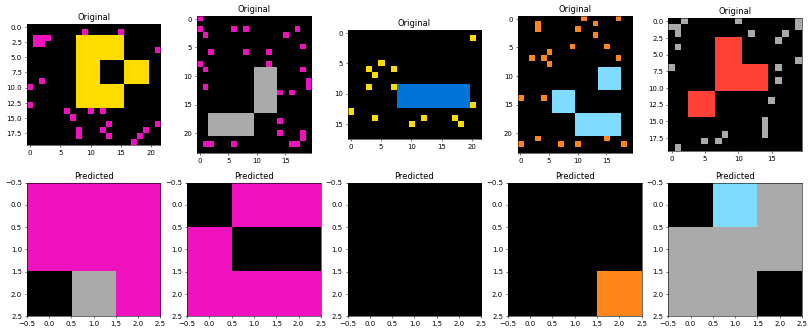

In [89]:
compare_plots(load_results(path, 'FullyCon_wrong_pred_T7'), n=5) # 5 wrong predictions

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:54<00:00, 46.90s/it]


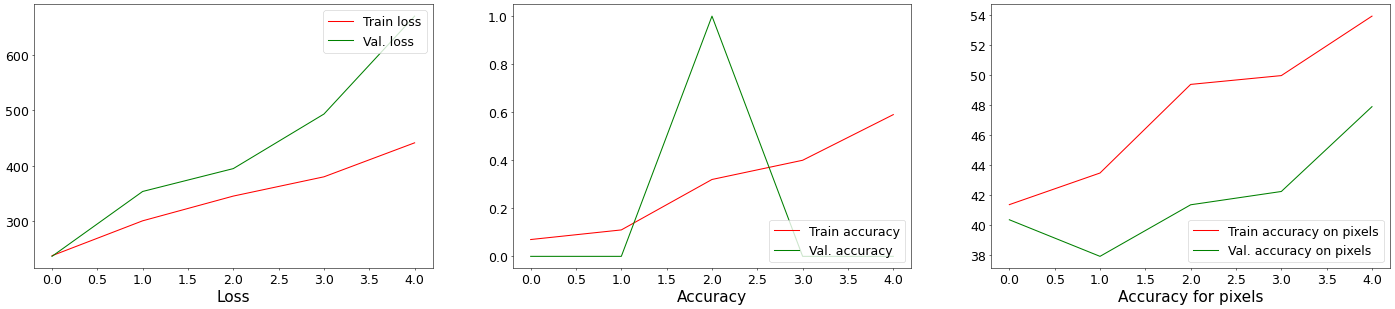

In [90]:
# Training
FullyConDeep_result_T7, FullyConDeep__predictions_T7, FullyConDeep_wrong_pred_T7 = evaluate_metrics(TaskSolver(), 
                                                                                        data, 
                                                                                        FullyCon_deep_T7, CrossEntropyLoss, 
                                                                                        n_epoch=5, device=device,
                                                                                        lr = 0.1, verbose=False, 
                                                                                        attention = False)

save_results(path, [FullyConDeep_result_T7, FullyConDeep__predictions_T7, FullyConDeep_wrong_pred_T7], 
             ['FullyConDeep_result_T7', 'FullyConDeep__predictions_T7', 'FullyConDeep_wrong_pred_T7'])


plot_metrics(load_results(path, 'FullyConDeep_result_T7'))

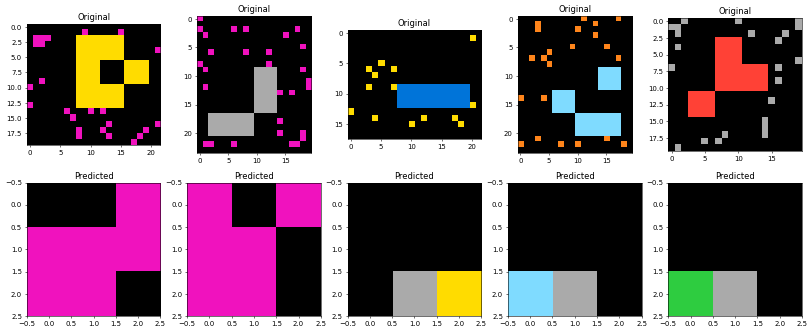

In [91]:
compare_plots(load_results(path, 'FullyConDeep_wrong_pred_T7'), n=5) # 5 wrong predictions

### CNN

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:41<00:00, 56.40s/it]


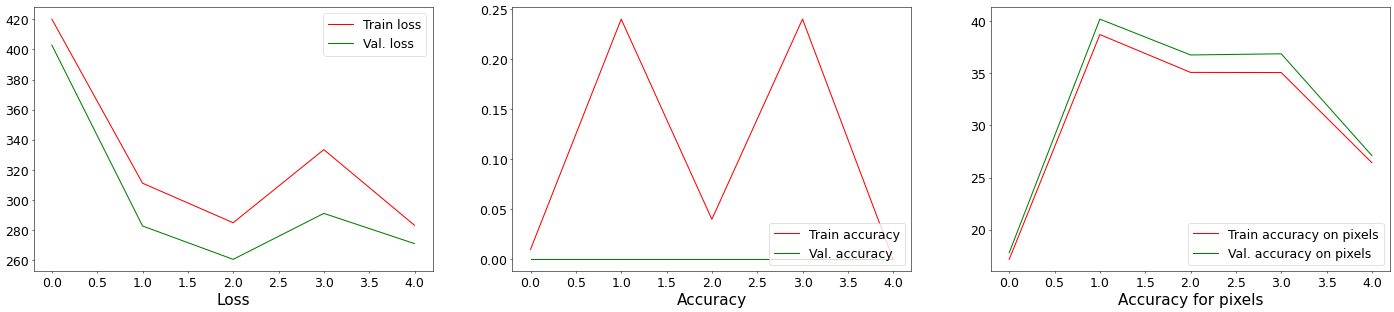

In [94]:
CNN_result_T7, CNN_predictions_T7, CNN_wrong_pred_T7 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_5_T7, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [CNN_result_T7, CNN_predictions_T7, CNN_wrong_pred_T7], 
             ['CNN_result_T7', 'CNN_predictions_T7', 'CNN_wrong_pred_T7'])


plot_metrics(load_results(path,'CNN_result_T7'))

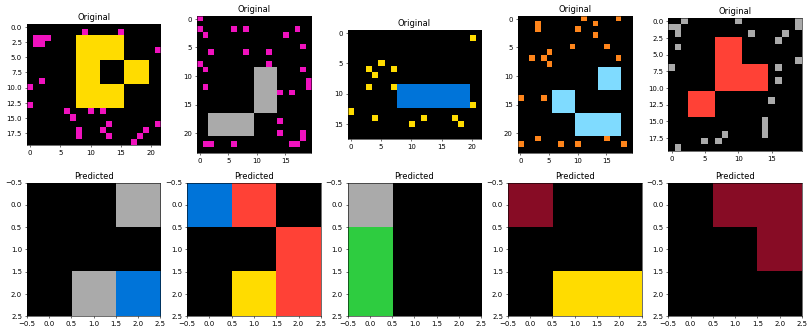

In [95]:
compare_plots(load_results(path, 'CNN_wrong_pred_T7'), n=5) # 5 wrong predictions

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:41<00:00, 44.30s/it]


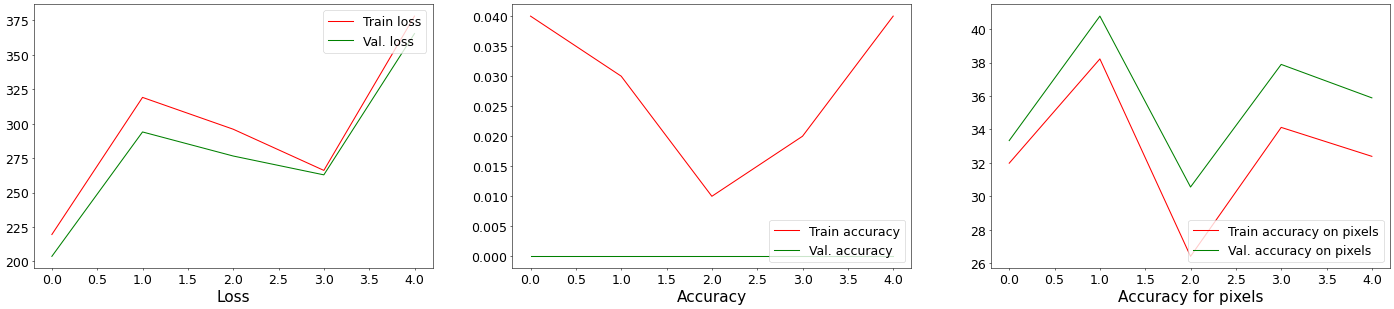

In [96]:
CNN_no_result_T7, CNN_no_predictions_T7, CNN_no_wrong_pred_T7 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_5_T7, CrossEntropyLoss, 
                                                                            attention = None,
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [CNN_no_result_T7, CNN_no_predictions_T7, CNN_no_wrong_pred_T7], 
             ['CNN_no_result_T7', 'CNN_no_predictions_T7', 'CNN_no_wrong_pred_T7'])


plot_metrics(load_results(path,'CNN_no_result_T7'))

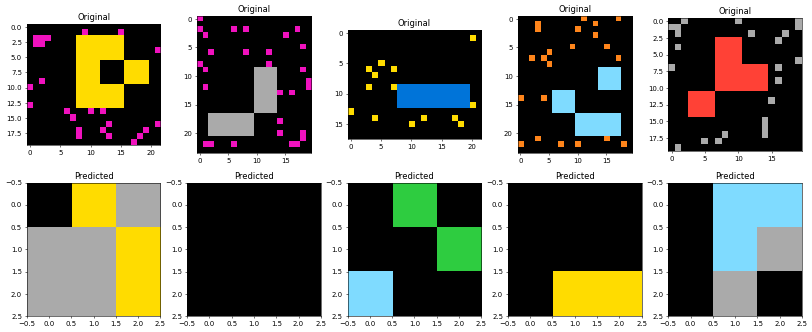

In [97]:
compare_plots(load_results(path, 'CNN_no_wrong_pred_T7'), n=5) # 5 wrong predictions

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:33<00:00, 54.74s/it]


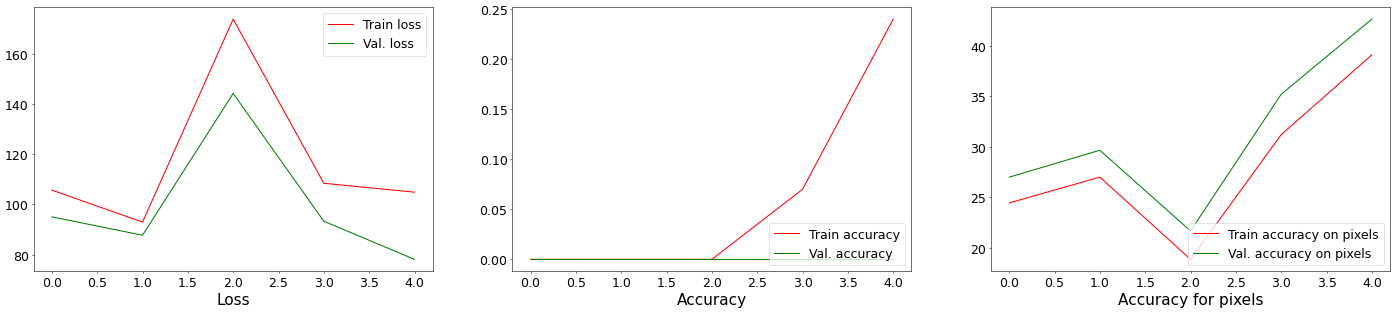

In [98]:
CNN3_result_T7, CNN3_predictions_T7, CNN3_wrong_pred_T7 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            CNN_3_T7, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [CNN3_result_T7, CNN3_predictions_T7, CNN3_wrong_pred_T7], 
             ['CNN3_result_T7', 'CNN3_predictions_T7', 'CNN3_wrong_pred_T7'])


plot_metrics(load_results(path,'CNN3_result_T7'))

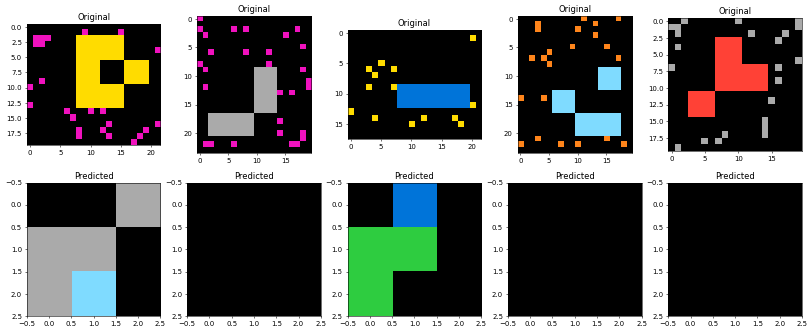

In [99]:
compare_plots(load_results(path, 'CNN3_wrong_pred_T7'), n=5) # 5 wrong predictions

### LSTM

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:18<00:00, 63.77s/it]


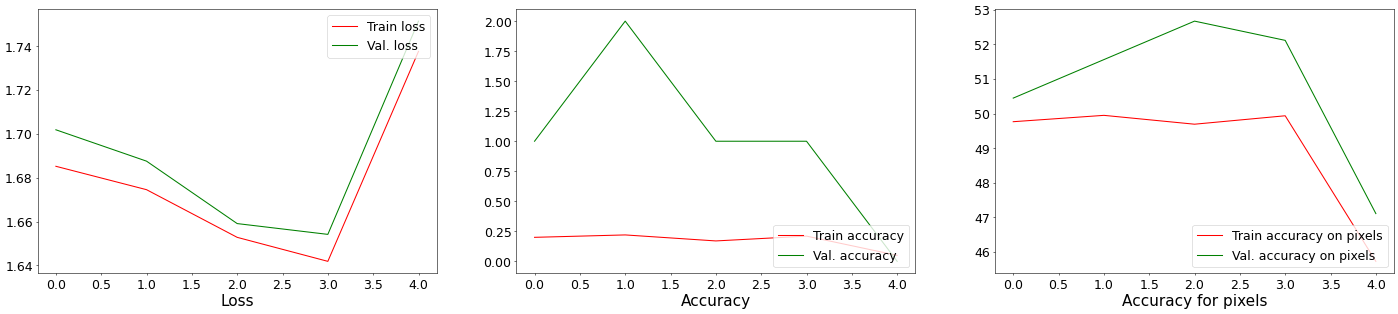

In [100]:
# Training with attention
LSTM_result_T7, LSTM_predictions_T7, LSTM_wrong_pred_T7 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            LSTM_T7, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [LSTM_result_T7, LSTM_predictions_T7, LSTM_wrong_pred_T7], 
             ['LSTM_result_T7', 'LSTM_predictions_T7', 'LSTM_wrong_pred_T7'])


plot_metrics(load_results(path, 'LSTM_result_T7'))


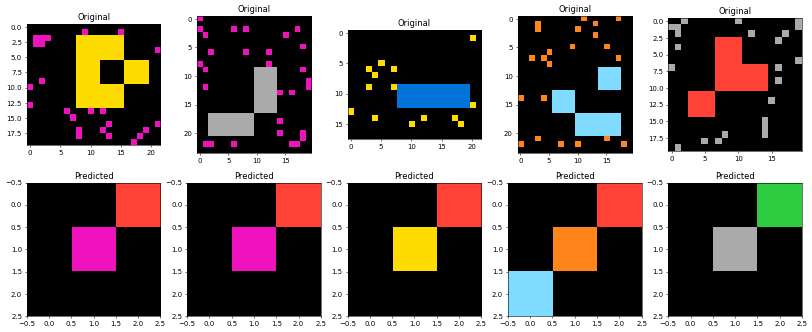

In [101]:
compare_plots(load_results(path, 'LSTM_wrong_pred_T7'), n=5) # 5 wrong predictions

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:08<00:00, 49.68s/it]


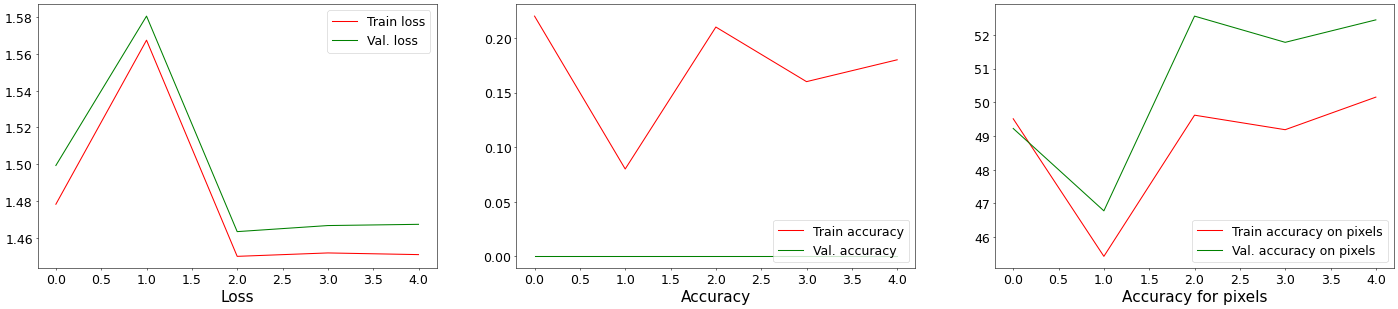

In [102]:
# Training 
LSTM_no_result_T7, LSTM_no_predictions_T7, LSTM_no_wrong_pred_T7 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            LSTM_T7, CrossEntropyLoss, 
                                                                            attention = None,
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [LSTM_no_result_T7, LSTM_no_predictions_T7, LSTM_no_wrong_pred_T7], 
             ['LSTM_no_result_T7', 'LSTM_no_predictions_T7', 'LSTM_no_wrong_pred_T7'])


plot_metrics(load_results(path, 'LSTM_no_result_T7'))


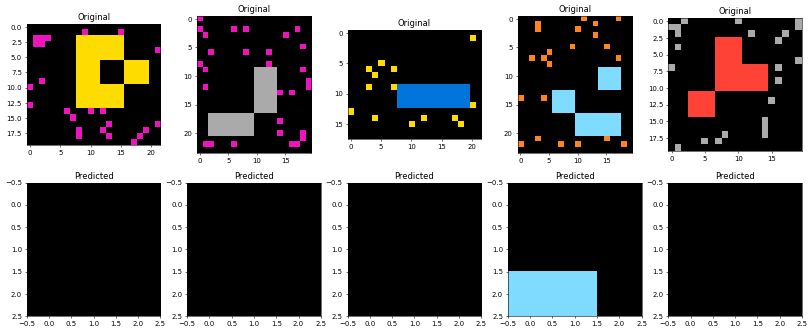

In [103]:
compare_plots(load_results(path, 'LSTM_no_wrong_pred_T7'), n=5) # 5 wrong predictions

### GRU

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:15<00:00, 63.06s/it]


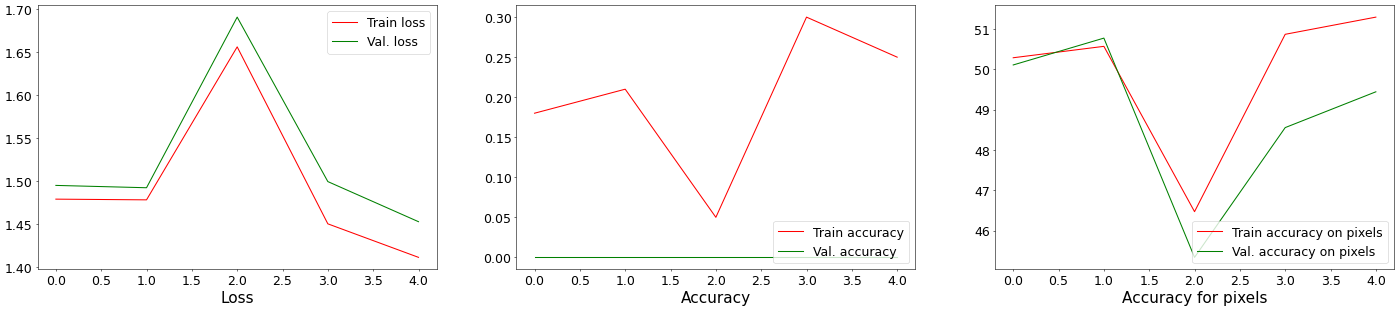

In [104]:
# Training with attention
GRU_result_T7, GRU_predictions_T7, GRU_wrong_pred_T7 = evaluate_metrics(TaskSolver(), 
                                                                            data, 
                                                                            GRU_T7, CrossEntropyLoss, 
                                                                            attention = 'yes',
                                                                            n_epoch=5, device=device,
                                                                            lr = 0.1, verbose=False)

save_results(path, [GRU_result_T7, GRU_predictions_T7, GRU_wrong_pred_T7], 
             ['GRU_result_T7', 'GRU_predictions_T7', 'GRU_wrong_pred_T7'])


plot_metrics(load_results(path, 'GRU_result_T7'))


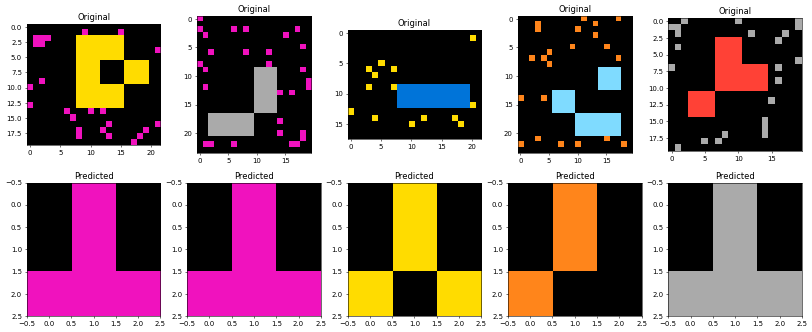

In [105]:
compare_plots(load_results(path, 'GRU_wrong_pred_T7'), n=5) # 5 wrong predictions